In [ ]:
#Method 2
#cluster timestamps using k-means, and select the frames close to the cluster center
import os
import sys
import h5py
import numpy as np
from sklearn.cluster import KMeans
from shutil import copyfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

args_data_name="1226"
args_dataset="/4t/yangchihyuan/TransmittedImages/datasets/Zenbo_"+args_data_name+"_clear_Charade.h5"
args_image_directory="/4t/yangchihyuan/TransmittedImages/"+args_data_name
args_copy_to_directory="/4t/yangchihyuan/TransmittedImages/keyframes/method2_time_kmeans/"+args_data_name
args_number_of_clusters=8

dataset = h5py.File(args_dataset, 'r')
feature_matrix = dataset[args_data_name]['features'][...]
file_list = dataset[args_data_name]['file_list'][...]
number_of_images = feature_matrix.shape[0]
print('number_of_images', number_of_images)

timestamps = []
idx = 0
for filename in file_list:
    timestamps.append( int(filename[:-4]))
    idx = idx +1

feature_matrix = np.reshape(timestamps ,(-1,1))
number_of_samples = number_of_images
kmeans = KMeans(n_clusters=args_number_of_clusters, random_state=0).fit(feature_matrix)
print(kmeans.cluster_centers_)
for cluster_center in kmeans.cluster_centers_:
    diff = feature_matrix - np.tile(cluster_center,(number_of_samples,1))
    square = diff * diff
    l2_norm = np.sqrt(np.sum(square,axis=1))
#    print('l2_norm', l2_norm.shape, l2_norm)
    index = np.argsort(l2_norm)[0]
#    print('index', index)
#    print(file_list[index])
    file_name = file_list[index]
    if( os.path.exists(args_copy_to_directory) == False):
        os.mkdir(args_copy_to_directory)
    img=mpimg.imread(os.path.join(args_image_directory,file_name))
    plt.figure()
    imgplot = plt.imshow(img)        
    copyfile(os.path.join(args_image_directory,file_name), os.path.join(args_copy_to_directory,file_name))
    

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
('number_of_images', 19971)
('J', [7, 6, 5, 4, 3, 2, 1, 0])
('elapsed', 690.8105630874634)
Finished. Total elapsed time (h:m:s): 0:11:30.810563


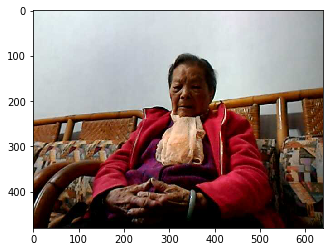

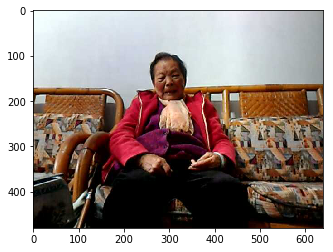

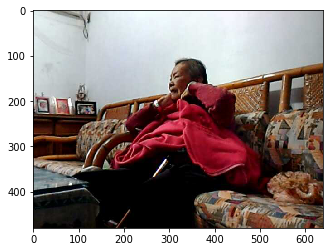

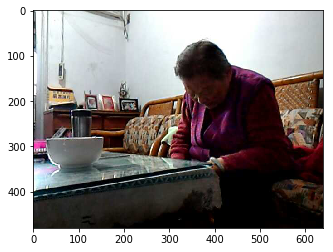

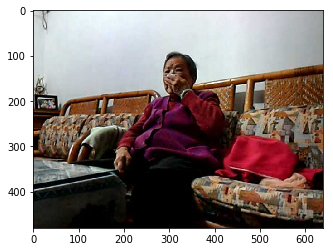

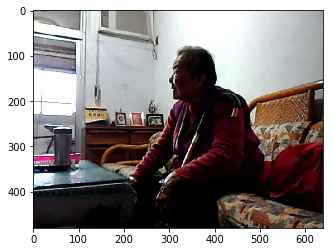

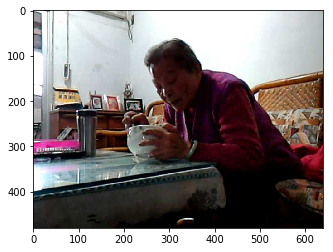

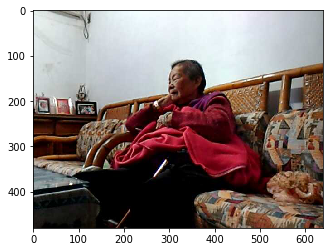

In [3]:
#Method 4 DPP
#concatenate timestamps feature_matrix and select keyframes using k-dpp
%reset
import os
from dpp import util
from dpp import k_dpp
import matplotlib.image as mpimg
import h5py
import numpy as np
#from datetime import datetime
import matplotlib.pyplot as plt
from shutil import copyfile
import time
import datetime

args_data_name="1226"
args_dataset="/4t/yangchihyuan/TransmittedImages/datasets/"+args_data_name+"_effective_Charade.h5"
args_image_directory="/4t/yangchihyuan/TransmittedImages/"+args_data_name
args_number_of_clusters=8
args_copy_to_directory="/4t/yangchihyuan/TransmittedImages/keyframes/method4_dpp/" + args_data_name

args_do_copy = True

dataset = h5py.File(args_dataset, 'r')
feature_matrix = dataset[args_data_name]['features'][...]
file_list = dataset[args_data_name]['file_list'][...]
number_of_images = feature_matrix.shape[0]
print('number_of_images', number_of_images)

#convert the file_list into a list of timestamps
start_time = time.time()

timestamps = []
idx = 0
for filename in file_list:
    timestamps.append( int(filename[:-4]))
    idx = idx +1

number_of_images = len(timestamps)
duration = timestamps[-1] - timestamps[0]

alpha = 0.5  #the weight of timestamp
feature_matrix_concatenated = np.empty((number_of_images,158), dtype=np.float64)
for idx in range(0,number_of_images):
    feature_matrix_concatenated[idx,0]=float(timestamps[idx]-timestamps[0])/duration*alpha
#    print(feature_matrix_concatenated[idx,0])
    feature_matrix_concatenated[idx,1::]=feature_matrix[idx,:]

#there are too many frames, I prefer to sample them by a step
step = 1   #1 means no subsampling
downsample_set = range(0,number_of_images, step)
feature_matrix_concatenated_downsampled = feature_matrix_concatenated[downsample_set,:]
number_of_images_downsample = len(downsample_set)

#create the distance matrix
#distance_matrix = np.empty((number_of_images_downsample, number_of_images_downsample), dtype=np.float64)
#for idx in range(0,number_of_images_downsample):
#    feature = feature_matrix_concatenated_downsampled[idx,:]
#    tile_feature = np.tile(feature,[number_of_images_downsample,1])
#    diff = tile_feature - feature_matrix_concatenated_downsampled
#    square = diff * diff
#    l2_norm = np.sqrt(np.sum(square,axis=1))
#    distance_matrix[:,idx] = l2_norm
#print(distance_matrix)
#distance_matrix_backup = distance_matrix

#try to reduce half computation load by only computing the lower diagnose
distance_matrix = np.empty((number_of_images_downsample, number_of_images_downsample), dtype=np.float64)
for idx in range(0,number_of_images_downsample-1):
    feature = feature_matrix_concatenated_downsampled[idx,:]
    fillin_range = range(idx+1,number_of_images_downsample)
    range_length = number_of_images_downsample - 1 -idx
    tile_feature = np.tile(feature,[range_length,1])
    diff = tile_feature - feature_matrix_concatenated_downsampled[fillin_range,:]
    square = diff * diff
    l2_norm = np.sqrt(np.sum(square,axis=1))
    distance_matrix[fillin_range,idx] = l2_norm

#fill 0 in the diag
for idx in range(0,number_of_images_downsample):
    distance_matrix[idx,idx] = 0
    
#copy the symmetric elemetns    
for i in range(0,number_of_images_downsample):
    for j in range(i+1,number_of_images_downsample):
        distance_matrix[i,j] = distance_matrix[j,i]
    
#check whether the two matrixes are the same
#diff = distance_matrix_backup - distance_matrix
#print('np.count_nonzero(diff)',np.count_nonzero(diff))
    
D, V = util.decompose_kernel(distance_matrix)
#print(D)
k = 8
Y = k_dpp.k_sample(k, D, V)

elapsed = time.time() - start_time
print('elapsed',elapsed)
elapsed = str(datetime.timedelta(seconds=elapsed))
print("Finished. Total elapsed time (h:m:s): {}".format(elapsed))

#check whether copy_to_directory exists
if( os.path.exists(args_copy_to_directory) == False):
    os.mkdir(args_copy_to_directory)
else:
    #remove old files
    os.system("rm " + args_copy_to_directory +"/*")

#print(Y)
for idx in Y:
    index_global = downsample_set[int(idx)]
    file_name = file_list[index_global]
#    value = datetime.fromtimestamp(timestamps[index_global]/1000)
#    print('file_name', file_name, 'index_global', index_global, 'time', value.strftime('%H:%M'))
    img=mpimg.imread(os.path.join(args_image_directory,file_name))
    plt.figure()
    imgplot = plt.imshow(img)
    if args_do_copy:
        copyfile(os.path.join(args_image_directory,file_name), os.path.join(args_copy_to_directory,file_name))

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
('number_of_images', 3115)
('time_gap_threshold', 60000)
('number of clusters', 35)
('time_gap_threshold', 120000)
('number of clusters', 17)
update
('time_gap_threshold', 240000)
('number of clusters', 6)
('number of index in each cluster', [35, 451, 114, 38, 125, 9, 176, 63, 104, 118, 3, 235, 35, 384, 89, 478, 658])
('order_by_size', array([16, 15,  1, 13, 11,  6,  4,  9,  2,  8, 14,  7,  3, 12,  0,  5, 10]))
('index_global', 2576)
('file_name', '1555664092036.jpg')
('index_global', 2228)
('file_name', '1555663594209.jpg')
('index_global', 477)
('file_name', '1555656171704.jpg')
('index_global', 1776)
('file_name', '1555662389595.jpg')
('index_global', 1326)
('file_name', '1555661194459.jpg')
('index_global', 931)
('file_name', '1555658870690.jpg')
('index_global', 743)
('file_name', '1555657928495.jpg')
('index_global', 1231)
('file_name', '1555660473082.jpg')
('elapsed', '0:00:00.215260')
Finished. Total elapsed time (

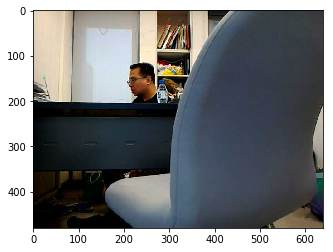

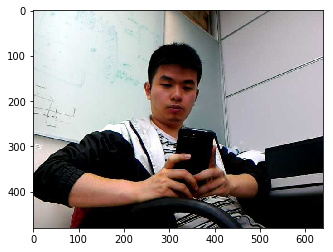

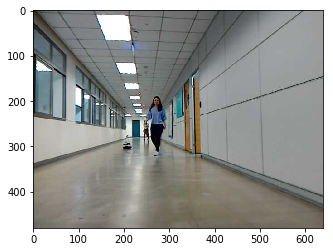

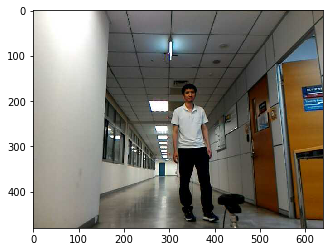

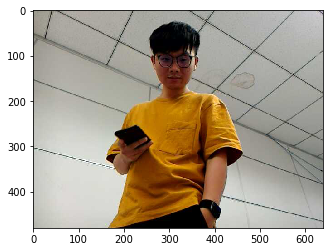

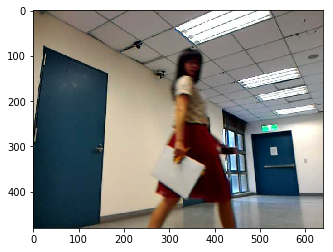

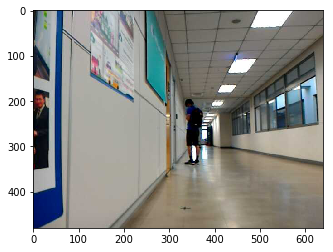

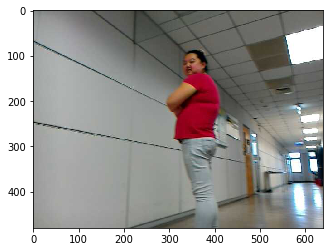

In [24]:
#Method 3
#compute the mean of the features in each cluster. This is the representative set.
#sort the nested_list_timestamp by the numbers of frames contained in clusters
%reset
import os
import sys
import h5py
import numpy as np
from sklearn.cluster import KMeans
from shutil import copyfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import json
import time
import datetime

args_data_name="0419_lab"
args_dataset="/4t/yangchihyuan/TransmittedImages/datasets/"+args_data_name+"_effective_Charade.h5"
args_image_directory="/4t/yangchihyuan/TransmittedImages/"+args_data_name
args_number_of_clusters=8
args_copy_to_directory="/4t/yangchihyuan/TransmittedImages/keyframes/method3_time_action/"+args_data_name
args_save_clusters_directory="/4t/yangchihyuan/TransmittedImages/clusters/method3_time_action/"
args_save_clusters_file=args_save_clusters_directory+args_data_name+".json"

dataset = h5py.File(args_dataset, 'r')
feature_matrix = dataset[args_data_name]['features'][...]
file_list = dataset[args_data_name]['file_list'][...]
number_of_images = int(feature_matrix.shape[0])
feature_dimension = int(feature_matrix.shape[1])
print('number_of_images', number_of_images)

#convert the file_list into a list of timestamps
timestamps = []
idx = 0
for filename in file_list:
    timestamps.append( int(filename[:-4]))
    idx = idx +1

duration = timestamps[-1] - timestamps[0]

start_time = time.time()
time_gap_threshold = 60000  #1 minute

def calculate_number_of_cluster(time_gap_threshold):
    print('time_gap_threshold',time_gap_threshold)
    next_timestamp = timestamps[0]
    clusters = []
    cluster = [0]
    for idx in range(1,number_of_images):
        previous_timestamp = next_timestamp
        next_timestamp = timestamps[idx]
        if next_timestamp - previous_timestamp < time_gap_threshold:
            cluster.append(idx)
        else:
            clusters.append(cluster)
            cluster = [idx]
    clusters.append(cluster)   #add the last cluster

    number_of_clusters = len(clusters)
    print('number of clusters',number_of_clusters)
    return number_of_clusters, clusters

#initial calculation
number_of_clusters, clusters = calculate_number_of_cluster(time_gap_threshold)
number_of_clusters_save = number_of_clusters
clusters_save = clusters
#loop
while True:
    if number_of_clusters < args_number_of_clusters:
        time_gap_threshold = time_gap_threshold / 2
    else:
        time_gap_threshold = time_gap_threshold * 2
    
    number_of_clusters, clusters = calculate_number_of_cluster(time_gap_threshold)
    if number_of_clusters < 8:
        break
    else:
        #update
        print('update')
        number_of_clusters_save = number_of_clusters
        clusters_save = clusters
        
#restore        
number_of_clusters = number_of_clusters_save
clusters = clusters_save
        
number_of_indices_list = [len(cluster) for cluster in clusters]
print('number of index in each cluster',number_of_indices_list)
order_by_size = np.argsort(number_of_indices_list)[::-1]
print('order_by_size', order_by_size)

averaged_feature_list = []

#check whether copy_to_directory exists
if( os.path.exists(args_copy_to_directory) == False):
    os.makedirs(args_copy_to_directory)
else:
    #remove old files
    os.system("rm " + args_copy_to_directory +"/*")

if( os.path.exists(args_save_clusters_directory) == False):
    os.makedirs(args_save_clusters_directory)
    
for idx_cluster in order_by_size[0:8]:
    cluster = clusters[idx_cluster]
    number_of_images = len(cluster)
    feature_sum = np.zeros((number_of_images,feature_dimension), dtype=np.float32)
    feature_in_cluster = feature_matrix[cluster,:]
    averaged_feature = np.mean(feature_in_cluster, axis=0)
    averaged_feature_list.append(averaged_feature)
    diff = feature_in_cluster - np.tile(averaged_feature,(number_of_images,1))
    square = diff * diff
    l2_norm = np.sqrt(np.sum(square,axis=1))
    index_representative = np.argsort(l2_norm)[0]
    index_global = cluster[index_representative]
    print('index_global', index_global)
    file_name = file_list[index_global]
    print('file_name', file_name)
    img=mpimg.imread(os.path.join(args_image_directory,file_name))
    plt.figure()
    imgplot = plt.imshow(img)
    copyfile(os.path.join(args_image_directory,file_name), os.path.join(args_copy_to_directory,file_name))

elapsed = time.time() - start_time
elapsed = str(datetime.timedelta(seconds=elapsed))
print('elapsed',elapsed)
print("Finished. Total elapsed time (h:m:s): {}".format(elapsed))
    
    
#save the segment result into a json file
with open(args_save_clusters_file, 'w') as outfile:
    json.dump(clusters, outfile)

In [5]:
#Extract 3: HSV histogram features
#For VSUMM
%reset
import cv2
import os
import numpy as np
import h5py

args_data_name="1226"
args_dataset="/4t/yangchihyuan/TransmittedImages/datasets/"+args_data_name+"_effective_HSV_histogram.h5"
args_image_directory="/4t/yangchihyuan/TransmittedImages/"+args_data_name
args_listfile="/4t/yangchihyuan/TransmittedImages/filelist/"+args_data_name+"_effective.txt"

with open(args_listfile ,'r') as f:
    file_list = f.readlines()
file_list = [x.strip() for x in file_list] #remove \n
number_of_images = len(file_list)

feature_matrix = np.empty([number_of_images, 4096],dtype=np.float64)
for idx in range(0,number_of_images):
    print(idx,number_of_images)
    filename = file_list[idx]
    img = cv2.imread(os.path.join(args_image_directory,filename))
    height = img.shape[0]
    width = img.shape[1]
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    number_of_bins = [16, 16, 16]
    value_range = [0, 180, 0, 256, 0, 256]
    hist = cv2.calcHist([hsv], [0, 1, 2], None, number_of_bins, value_range) #hist is a 16x16x16 array
    feature_matrix[idx,:] = np.reshape(hist,(1,4096)) / (height*width)  #normalize the distribution
    
f = h5py.File(args_dataset, 'w')
f.create_dataset(args_data_name + '/hsv_histogram', data=feature_matrix)
f.create_dataset(args_data_name + '/n_frames', data=idx)
f.create_dataset(args_data_name + '/file_list', data=file_list)
f.close()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
(0, 19971)
(1, 19971)
(2, 19971)
(3, 19971)
(4, 19971)
(5, 19971)
(6, 19971)
(7, 19971)
(8, 19971)
(9, 19971)
(10, 19971)
(11, 19971)
(12, 19971)
(13, 19971)
(14, 19971)
(15, 19971)
(16, 19971)
(17, 19971)
(18, 19971)
(19, 19971)
(20, 19971)
(21, 19971)
(22, 19971)
(23, 19971)
(24, 19971)
(25, 19971)
(26, 19971)
(27, 19971)
(28, 19971)
(29, 19971)
(30, 19971)
(31, 19971)
(32, 19971)
(33, 19971)
(34, 19971)
(35, 19971)
(36, 19971)
(37, 19971)
(38, 19971)
(39, 19971)
(40, 19971)
(41, 19971)
(42, 19971)
(43, 19971)
(44, 19971)
(45, 19971)
(46, 19971)
(47, 19971)
(48, 19971)
(49, 19971)
(50, 19971)
(51, 19971)
(52, 19971)
(53, 19971)
(54, 19971)
(55, 19971)
(56, 19971)
(57, 19971)
(58, 19971)
(59, 19971)
(60, 19971)
(61, 19971)
(62, 19971)
(63, 19971)
(64, 19971)
(65, 19971)
(66, 19971)
(67, 19971)
(68, 19971)
(69, 19971)
(70, 19971)
(71, 19971)
(72, 19971)
(73, 19971)
(74, 19971)
(75, 19971)
(76, 19971)
(77, 19971)
(78, 19971

(660, 19971)
(661, 19971)
(662, 19971)
(663, 19971)
(664, 19971)
(665, 19971)
(666, 19971)
(667, 19971)
(668, 19971)
(669, 19971)
(670, 19971)
(671, 19971)
(672, 19971)
(673, 19971)
(674, 19971)
(675, 19971)
(676, 19971)
(677, 19971)
(678, 19971)
(679, 19971)
(680, 19971)
(681, 19971)
(682, 19971)
(683, 19971)
(684, 19971)
(685, 19971)
(686, 19971)
(687, 19971)
(688, 19971)
(689, 19971)
(690, 19971)
(691, 19971)
(692, 19971)
(693, 19971)
(694, 19971)
(695, 19971)
(696, 19971)
(697, 19971)
(698, 19971)
(699, 19971)
(700, 19971)
(701, 19971)
(702, 19971)
(703, 19971)
(704, 19971)
(705, 19971)
(706, 19971)
(707, 19971)
(708, 19971)
(709, 19971)
(710, 19971)
(711, 19971)
(712, 19971)
(713, 19971)
(714, 19971)
(715, 19971)
(716, 19971)
(717, 19971)
(718, 19971)
(719, 19971)
(720, 19971)
(721, 19971)
(722, 19971)
(723, 19971)
(724, 19971)
(725, 19971)
(726, 19971)
(727, 19971)
(728, 19971)
(729, 19971)
(730, 19971)
(731, 19971)
(732, 19971)
(733, 19971)
(734, 19971)
(735, 19971)
(736, 19971)

(1283, 19971)
(1284, 19971)
(1285, 19971)
(1286, 19971)
(1287, 19971)
(1288, 19971)
(1289, 19971)
(1290, 19971)
(1291, 19971)
(1292, 19971)
(1293, 19971)
(1294, 19971)
(1295, 19971)
(1296, 19971)
(1297, 19971)
(1298, 19971)
(1299, 19971)
(1300, 19971)
(1301, 19971)
(1302, 19971)
(1303, 19971)
(1304, 19971)
(1305, 19971)
(1306, 19971)
(1307, 19971)
(1308, 19971)
(1309, 19971)
(1310, 19971)
(1311, 19971)
(1312, 19971)
(1313, 19971)
(1314, 19971)
(1315, 19971)
(1316, 19971)
(1317, 19971)
(1318, 19971)
(1319, 19971)
(1320, 19971)
(1321, 19971)
(1322, 19971)
(1323, 19971)
(1324, 19971)
(1325, 19971)
(1326, 19971)
(1327, 19971)
(1328, 19971)
(1329, 19971)
(1330, 19971)
(1331, 19971)
(1332, 19971)
(1333, 19971)
(1334, 19971)
(1335, 19971)
(1336, 19971)
(1337, 19971)
(1338, 19971)
(1339, 19971)
(1340, 19971)
(1341, 19971)
(1342, 19971)
(1343, 19971)
(1344, 19971)
(1345, 19971)
(1346, 19971)
(1347, 19971)
(1348, 19971)
(1349, 19971)
(1350, 19971)
(1351, 19971)
(1352, 19971)
(1353, 19971)
(1354,

(1877, 19971)
(1878, 19971)
(1879, 19971)
(1880, 19971)
(1881, 19971)
(1882, 19971)
(1883, 19971)
(1884, 19971)
(1885, 19971)
(1886, 19971)
(1887, 19971)
(1888, 19971)
(1889, 19971)
(1890, 19971)
(1891, 19971)
(1892, 19971)
(1893, 19971)
(1894, 19971)
(1895, 19971)
(1896, 19971)
(1897, 19971)
(1898, 19971)
(1899, 19971)
(1900, 19971)
(1901, 19971)
(1902, 19971)
(1903, 19971)
(1904, 19971)
(1905, 19971)
(1906, 19971)
(1907, 19971)
(1908, 19971)
(1909, 19971)
(1910, 19971)
(1911, 19971)
(1912, 19971)
(1913, 19971)
(1914, 19971)
(1915, 19971)
(1916, 19971)
(1917, 19971)
(1918, 19971)
(1919, 19971)
(1920, 19971)
(1921, 19971)
(1922, 19971)
(1923, 19971)
(1924, 19971)
(1925, 19971)
(1926, 19971)
(1927, 19971)
(1928, 19971)
(1929, 19971)
(1930, 19971)
(1931, 19971)
(1932, 19971)
(1933, 19971)
(1934, 19971)
(1935, 19971)
(1936, 19971)
(1937, 19971)
(1938, 19971)
(1939, 19971)
(1940, 19971)
(1941, 19971)
(1942, 19971)
(1943, 19971)
(1944, 19971)
(1945, 19971)
(1946, 19971)
(1947, 19971)
(1948,

(2480, 19971)
(2481, 19971)
(2482, 19971)
(2483, 19971)
(2484, 19971)
(2485, 19971)
(2486, 19971)
(2487, 19971)
(2488, 19971)
(2489, 19971)
(2490, 19971)
(2491, 19971)
(2492, 19971)
(2493, 19971)
(2494, 19971)
(2495, 19971)
(2496, 19971)
(2497, 19971)
(2498, 19971)
(2499, 19971)
(2500, 19971)
(2501, 19971)
(2502, 19971)
(2503, 19971)
(2504, 19971)
(2505, 19971)
(2506, 19971)
(2507, 19971)
(2508, 19971)
(2509, 19971)
(2510, 19971)
(2511, 19971)
(2512, 19971)
(2513, 19971)
(2514, 19971)
(2515, 19971)
(2516, 19971)
(2517, 19971)
(2518, 19971)
(2519, 19971)
(2520, 19971)
(2521, 19971)
(2522, 19971)
(2523, 19971)
(2524, 19971)
(2525, 19971)
(2526, 19971)
(2527, 19971)
(2528, 19971)
(2529, 19971)
(2530, 19971)
(2531, 19971)
(2532, 19971)
(2533, 19971)
(2534, 19971)
(2535, 19971)
(2536, 19971)
(2537, 19971)
(2538, 19971)
(2539, 19971)
(2540, 19971)
(2541, 19971)
(2542, 19971)
(2543, 19971)
(2544, 19971)
(2545, 19971)
(2546, 19971)
(2547, 19971)
(2548, 19971)
(2549, 19971)
(2550, 19971)
(2551,

(3081, 19971)
(3082, 19971)
(3083, 19971)
(3084, 19971)
(3085, 19971)
(3086, 19971)
(3087, 19971)
(3088, 19971)
(3089, 19971)
(3090, 19971)
(3091, 19971)
(3092, 19971)
(3093, 19971)
(3094, 19971)
(3095, 19971)
(3096, 19971)
(3097, 19971)
(3098, 19971)
(3099, 19971)
(3100, 19971)
(3101, 19971)
(3102, 19971)
(3103, 19971)
(3104, 19971)
(3105, 19971)
(3106, 19971)
(3107, 19971)
(3108, 19971)
(3109, 19971)
(3110, 19971)
(3111, 19971)
(3112, 19971)
(3113, 19971)
(3114, 19971)
(3115, 19971)
(3116, 19971)
(3117, 19971)
(3118, 19971)
(3119, 19971)
(3120, 19971)
(3121, 19971)
(3122, 19971)
(3123, 19971)
(3124, 19971)
(3125, 19971)
(3126, 19971)
(3127, 19971)
(3128, 19971)
(3129, 19971)
(3130, 19971)
(3131, 19971)
(3132, 19971)
(3133, 19971)
(3134, 19971)
(3135, 19971)
(3136, 19971)
(3137, 19971)
(3138, 19971)
(3139, 19971)
(3140, 19971)
(3141, 19971)
(3142, 19971)
(3143, 19971)
(3144, 19971)
(3145, 19971)
(3146, 19971)
(3147, 19971)
(3148, 19971)
(3149, 19971)
(3150, 19971)
(3151, 19971)
(3152,

(3685, 19971)
(3686, 19971)
(3687, 19971)
(3688, 19971)
(3689, 19971)
(3690, 19971)
(3691, 19971)
(3692, 19971)
(3693, 19971)
(3694, 19971)
(3695, 19971)
(3696, 19971)
(3697, 19971)
(3698, 19971)
(3699, 19971)
(3700, 19971)
(3701, 19971)
(3702, 19971)
(3703, 19971)
(3704, 19971)
(3705, 19971)
(3706, 19971)
(3707, 19971)
(3708, 19971)
(3709, 19971)
(3710, 19971)
(3711, 19971)
(3712, 19971)
(3713, 19971)
(3714, 19971)
(3715, 19971)
(3716, 19971)
(3717, 19971)
(3718, 19971)
(3719, 19971)
(3720, 19971)
(3721, 19971)
(3722, 19971)
(3723, 19971)
(3724, 19971)
(3725, 19971)
(3726, 19971)
(3727, 19971)
(3728, 19971)
(3729, 19971)
(3730, 19971)
(3731, 19971)
(3732, 19971)
(3733, 19971)
(3734, 19971)
(3735, 19971)
(3736, 19971)
(3737, 19971)
(3738, 19971)
(3739, 19971)
(3740, 19971)
(3741, 19971)
(3742, 19971)
(3743, 19971)
(3744, 19971)
(3745, 19971)
(3746, 19971)
(3747, 19971)
(3748, 19971)
(3749, 19971)
(3750, 19971)
(3751, 19971)
(3752, 19971)
(3753, 19971)
(3754, 19971)
(3755, 19971)
(3756,

(4289, 19971)
(4290, 19971)
(4291, 19971)
(4292, 19971)
(4293, 19971)
(4294, 19971)
(4295, 19971)
(4296, 19971)
(4297, 19971)
(4298, 19971)
(4299, 19971)
(4300, 19971)
(4301, 19971)
(4302, 19971)
(4303, 19971)
(4304, 19971)
(4305, 19971)
(4306, 19971)
(4307, 19971)
(4308, 19971)
(4309, 19971)
(4310, 19971)
(4311, 19971)
(4312, 19971)
(4313, 19971)
(4314, 19971)
(4315, 19971)
(4316, 19971)
(4317, 19971)
(4318, 19971)
(4319, 19971)
(4320, 19971)
(4321, 19971)
(4322, 19971)
(4323, 19971)
(4324, 19971)
(4325, 19971)
(4326, 19971)
(4327, 19971)
(4328, 19971)
(4329, 19971)
(4330, 19971)
(4331, 19971)
(4332, 19971)
(4333, 19971)
(4334, 19971)
(4335, 19971)
(4336, 19971)
(4337, 19971)
(4338, 19971)
(4339, 19971)
(4340, 19971)
(4341, 19971)
(4342, 19971)
(4343, 19971)
(4344, 19971)
(4345, 19971)
(4346, 19971)
(4347, 19971)
(4348, 19971)
(4349, 19971)
(4350, 19971)
(4351, 19971)
(4352, 19971)
(4353, 19971)
(4354, 19971)
(4355, 19971)
(4356, 19971)
(4357, 19971)
(4358, 19971)
(4359, 19971)
(4360,

(4894, 19971)
(4895, 19971)
(4896, 19971)
(4897, 19971)
(4898, 19971)
(4899, 19971)
(4900, 19971)
(4901, 19971)
(4902, 19971)
(4903, 19971)
(4904, 19971)
(4905, 19971)
(4906, 19971)
(4907, 19971)
(4908, 19971)
(4909, 19971)
(4910, 19971)
(4911, 19971)
(4912, 19971)
(4913, 19971)
(4914, 19971)
(4915, 19971)
(4916, 19971)
(4917, 19971)
(4918, 19971)
(4919, 19971)
(4920, 19971)
(4921, 19971)
(4922, 19971)
(4923, 19971)
(4924, 19971)
(4925, 19971)
(4926, 19971)
(4927, 19971)
(4928, 19971)
(4929, 19971)
(4930, 19971)
(4931, 19971)
(4932, 19971)
(4933, 19971)
(4934, 19971)
(4935, 19971)
(4936, 19971)
(4937, 19971)
(4938, 19971)
(4939, 19971)
(4940, 19971)
(4941, 19971)
(4942, 19971)
(4943, 19971)
(4944, 19971)
(4945, 19971)
(4946, 19971)
(4947, 19971)
(4948, 19971)
(4949, 19971)
(4950, 19971)
(4951, 19971)
(4952, 19971)
(4953, 19971)
(4954, 19971)
(4955, 19971)
(4956, 19971)
(4957, 19971)
(4958, 19971)
(4959, 19971)
(4960, 19971)
(4961, 19971)
(4962, 19971)
(4963, 19971)
(4964, 19971)
(4965,

(5500, 19971)
(5501, 19971)
(5502, 19971)
(5503, 19971)
(5504, 19971)
(5505, 19971)
(5506, 19971)
(5507, 19971)
(5508, 19971)
(5509, 19971)
(5510, 19971)
(5511, 19971)
(5512, 19971)
(5513, 19971)
(5514, 19971)
(5515, 19971)
(5516, 19971)
(5517, 19971)
(5518, 19971)
(5519, 19971)
(5520, 19971)
(5521, 19971)
(5522, 19971)
(5523, 19971)
(5524, 19971)
(5525, 19971)
(5526, 19971)
(5527, 19971)
(5528, 19971)
(5529, 19971)
(5530, 19971)
(5531, 19971)
(5532, 19971)
(5533, 19971)
(5534, 19971)
(5535, 19971)
(5536, 19971)
(5537, 19971)
(5538, 19971)
(5539, 19971)
(5540, 19971)
(5541, 19971)
(5542, 19971)
(5543, 19971)
(5544, 19971)
(5545, 19971)
(5546, 19971)
(5547, 19971)
(5548, 19971)
(5549, 19971)
(5550, 19971)
(5551, 19971)
(5552, 19971)
(5553, 19971)
(5554, 19971)
(5555, 19971)
(5556, 19971)
(5557, 19971)
(5558, 19971)
(5559, 19971)
(5560, 19971)
(5561, 19971)
(5562, 19971)
(5563, 19971)
(5564, 19971)
(5565, 19971)
(5566, 19971)
(5567, 19971)
(5568, 19971)
(5569, 19971)
(5570, 19971)
(5571,

(6112, 19971)
(6113, 19971)
(6114, 19971)
(6115, 19971)
(6116, 19971)
(6117, 19971)
(6118, 19971)
(6119, 19971)
(6120, 19971)
(6121, 19971)
(6122, 19971)
(6123, 19971)
(6124, 19971)
(6125, 19971)
(6126, 19971)
(6127, 19971)
(6128, 19971)
(6129, 19971)
(6130, 19971)
(6131, 19971)
(6132, 19971)
(6133, 19971)
(6134, 19971)
(6135, 19971)
(6136, 19971)
(6137, 19971)
(6138, 19971)
(6139, 19971)
(6140, 19971)
(6141, 19971)
(6142, 19971)
(6143, 19971)
(6144, 19971)
(6145, 19971)
(6146, 19971)
(6147, 19971)
(6148, 19971)
(6149, 19971)
(6150, 19971)
(6151, 19971)
(6152, 19971)
(6153, 19971)
(6154, 19971)
(6155, 19971)
(6156, 19971)
(6157, 19971)
(6158, 19971)
(6159, 19971)
(6160, 19971)
(6161, 19971)
(6162, 19971)
(6163, 19971)
(6164, 19971)
(6165, 19971)
(6166, 19971)
(6167, 19971)
(6168, 19971)
(6169, 19971)
(6170, 19971)
(6171, 19971)
(6172, 19971)
(6173, 19971)
(6174, 19971)
(6175, 19971)
(6176, 19971)
(6177, 19971)
(6178, 19971)
(6179, 19971)
(6180, 19971)
(6181, 19971)
(6182, 19971)
(6183,

(6719, 19971)
(6720, 19971)
(6721, 19971)
(6722, 19971)
(6723, 19971)
(6724, 19971)
(6725, 19971)
(6726, 19971)
(6727, 19971)
(6728, 19971)
(6729, 19971)
(6730, 19971)
(6731, 19971)
(6732, 19971)
(6733, 19971)
(6734, 19971)
(6735, 19971)
(6736, 19971)
(6737, 19971)
(6738, 19971)
(6739, 19971)
(6740, 19971)
(6741, 19971)
(6742, 19971)
(6743, 19971)
(6744, 19971)
(6745, 19971)
(6746, 19971)
(6747, 19971)
(6748, 19971)
(6749, 19971)
(6750, 19971)
(6751, 19971)
(6752, 19971)
(6753, 19971)
(6754, 19971)
(6755, 19971)
(6756, 19971)
(6757, 19971)
(6758, 19971)
(6759, 19971)
(6760, 19971)
(6761, 19971)
(6762, 19971)
(6763, 19971)
(6764, 19971)
(6765, 19971)
(6766, 19971)
(6767, 19971)
(6768, 19971)
(6769, 19971)
(6770, 19971)
(6771, 19971)
(6772, 19971)
(6773, 19971)
(6774, 19971)
(6775, 19971)
(6776, 19971)
(6777, 19971)
(6778, 19971)
(6779, 19971)
(6780, 19971)
(6781, 19971)
(6782, 19971)
(6783, 19971)
(6784, 19971)
(6785, 19971)
(6786, 19971)
(6787, 19971)
(6788, 19971)
(6789, 19971)
(6790,

(7329, 19971)
(7330, 19971)
(7331, 19971)
(7332, 19971)
(7333, 19971)
(7334, 19971)
(7335, 19971)
(7336, 19971)
(7337, 19971)
(7338, 19971)
(7339, 19971)
(7340, 19971)
(7341, 19971)
(7342, 19971)
(7343, 19971)
(7344, 19971)
(7345, 19971)
(7346, 19971)
(7347, 19971)
(7348, 19971)
(7349, 19971)
(7350, 19971)
(7351, 19971)
(7352, 19971)
(7353, 19971)
(7354, 19971)
(7355, 19971)
(7356, 19971)
(7357, 19971)
(7358, 19971)
(7359, 19971)
(7360, 19971)
(7361, 19971)
(7362, 19971)
(7363, 19971)
(7364, 19971)
(7365, 19971)
(7366, 19971)
(7367, 19971)
(7368, 19971)
(7369, 19971)
(7370, 19971)
(7371, 19971)
(7372, 19971)
(7373, 19971)
(7374, 19971)
(7375, 19971)
(7376, 19971)
(7377, 19971)
(7378, 19971)
(7379, 19971)
(7380, 19971)
(7381, 19971)
(7382, 19971)
(7383, 19971)
(7384, 19971)
(7385, 19971)
(7386, 19971)
(7387, 19971)
(7388, 19971)
(7389, 19971)
(7390, 19971)
(7391, 19971)
(7392, 19971)
(7393, 19971)
(7394, 19971)
(7395, 19971)
(7396, 19971)
(7397, 19971)
(7398, 19971)
(7399, 19971)
(7400,

(7936, 19971)
(7937, 19971)
(7938, 19971)
(7939, 19971)
(7940, 19971)
(7941, 19971)
(7942, 19971)
(7943, 19971)
(7944, 19971)
(7945, 19971)
(7946, 19971)
(7947, 19971)
(7948, 19971)
(7949, 19971)
(7950, 19971)
(7951, 19971)
(7952, 19971)
(7953, 19971)
(7954, 19971)
(7955, 19971)
(7956, 19971)
(7957, 19971)
(7958, 19971)
(7959, 19971)
(7960, 19971)
(7961, 19971)
(7962, 19971)
(7963, 19971)
(7964, 19971)
(7965, 19971)
(7966, 19971)
(7967, 19971)
(7968, 19971)
(7969, 19971)
(7970, 19971)
(7971, 19971)
(7972, 19971)
(7973, 19971)
(7974, 19971)
(7975, 19971)
(7976, 19971)
(7977, 19971)
(7978, 19971)
(7979, 19971)
(7980, 19971)
(7981, 19971)
(7982, 19971)
(7983, 19971)
(7984, 19971)
(7985, 19971)
(7986, 19971)
(7987, 19971)
(7988, 19971)
(7989, 19971)
(7990, 19971)
(7991, 19971)
(7992, 19971)
(7993, 19971)
(7994, 19971)
(7995, 19971)
(7996, 19971)
(7997, 19971)
(7998, 19971)
(7999, 19971)
(8000, 19971)
(8001, 19971)
(8002, 19971)
(8003, 19971)
(8004, 19971)
(8005, 19971)
(8006, 19971)
(8007,

(8531, 19971)
(8532, 19971)
(8533, 19971)
(8534, 19971)
(8535, 19971)
(8536, 19971)
(8537, 19971)
(8538, 19971)
(8539, 19971)
(8540, 19971)
(8541, 19971)
(8542, 19971)
(8543, 19971)
(8544, 19971)
(8545, 19971)
(8546, 19971)
(8547, 19971)
(8548, 19971)
(8549, 19971)
(8550, 19971)
(8551, 19971)
(8552, 19971)
(8553, 19971)
(8554, 19971)
(8555, 19971)
(8556, 19971)
(8557, 19971)
(8558, 19971)
(8559, 19971)
(8560, 19971)
(8561, 19971)
(8562, 19971)
(8563, 19971)
(8564, 19971)
(8565, 19971)
(8566, 19971)
(8567, 19971)
(8568, 19971)
(8569, 19971)
(8570, 19971)
(8571, 19971)
(8572, 19971)
(8573, 19971)
(8574, 19971)
(8575, 19971)
(8576, 19971)
(8577, 19971)
(8578, 19971)
(8579, 19971)
(8580, 19971)
(8581, 19971)
(8582, 19971)
(8583, 19971)
(8584, 19971)
(8585, 19971)
(8586, 19971)
(8587, 19971)
(8588, 19971)
(8589, 19971)
(8590, 19971)
(8591, 19971)
(8592, 19971)
(8593, 19971)
(8594, 19971)
(8595, 19971)
(8596, 19971)
(8597, 19971)
(8598, 19971)
(8599, 19971)
(8600, 19971)
(8601, 19971)
(8602,

(9130, 19971)
(9131, 19971)
(9132, 19971)
(9133, 19971)
(9134, 19971)
(9135, 19971)
(9136, 19971)
(9137, 19971)
(9138, 19971)
(9139, 19971)
(9140, 19971)
(9141, 19971)
(9142, 19971)
(9143, 19971)
(9144, 19971)
(9145, 19971)
(9146, 19971)
(9147, 19971)
(9148, 19971)
(9149, 19971)
(9150, 19971)
(9151, 19971)
(9152, 19971)
(9153, 19971)
(9154, 19971)
(9155, 19971)
(9156, 19971)
(9157, 19971)
(9158, 19971)
(9159, 19971)
(9160, 19971)
(9161, 19971)
(9162, 19971)
(9163, 19971)
(9164, 19971)
(9165, 19971)
(9166, 19971)
(9167, 19971)
(9168, 19971)
(9169, 19971)
(9170, 19971)
(9171, 19971)
(9172, 19971)
(9173, 19971)
(9174, 19971)
(9175, 19971)
(9176, 19971)
(9177, 19971)
(9178, 19971)
(9179, 19971)
(9180, 19971)
(9181, 19971)
(9182, 19971)
(9183, 19971)
(9184, 19971)
(9185, 19971)
(9186, 19971)
(9187, 19971)
(9188, 19971)
(9189, 19971)
(9190, 19971)
(9191, 19971)
(9192, 19971)
(9193, 19971)
(9194, 19971)
(9195, 19971)
(9196, 19971)
(9197, 19971)
(9198, 19971)
(9199, 19971)
(9200, 19971)
(9201,

(9732, 19971)
(9733, 19971)
(9734, 19971)
(9735, 19971)
(9736, 19971)
(9737, 19971)
(9738, 19971)
(9739, 19971)
(9740, 19971)
(9741, 19971)
(9742, 19971)
(9743, 19971)
(9744, 19971)
(9745, 19971)
(9746, 19971)
(9747, 19971)
(9748, 19971)
(9749, 19971)
(9750, 19971)
(9751, 19971)
(9752, 19971)
(9753, 19971)
(9754, 19971)
(9755, 19971)
(9756, 19971)
(9757, 19971)
(9758, 19971)
(9759, 19971)
(9760, 19971)
(9761, 19971)
(9762, 19971)
(9763, 19971)
(9764, 19971)
(9765, 19971)
(9766, 19971)
(9767, 19971)
(9768, 19971)
(9769, 19971)
(9770, 19971)
(9771, 19971)
(9772, 19971)
(9773, 19971)
(9774, 19971)
(9775, 19971)
(9776, 19971)
(9777, 19971)
(9778, 19971)
(9779, 19971)
(9780, 19971)
(9781, 19971)
(9782, 19971)
(9783, 19971)
(9784, 19971)
(9785, 19971)
(9786, 19971)
(9787, 19971)
(9788, 19971)
(9789, 19971)
(9790, 19971)
(9791, 19971)
(9792, 19971)
(9793, 19971)
(9794, 19971)
(9795, 19971)
(9796, 19971)
(9797, 19971)
(9798, 19971)
(9799, 19971)
(9800, 19971)
(9801, 19971)
(9802, 19971)
(9803,

(10302, 19971)
(10303, 19971)
(10304, 19971)
(10305, 19971)
(10306, 19971)
(10307, 19971)
(10308, 19971)
(10309, 19971)
(10310, 19971)
(10311, 19971)
(10312, 19971)
(10313, 19971)
(10314, 19971)
(10315, 19971)
(10316, 19971)
(10317, 19971)
(10318, 19971)
(10319, 19971)
(10320, 19971)
(10321, 19971)
(10322, 19971)
(10323, 19971)
(10324, 19971)
(10325, 19971)
(10326, 19971)
(10327, 19971)
(10328, 19971)
(10329, 19971)
(10330, 19971)
(10331, 19971)
(10332, 19971)
(10333, 19971)
(10334, 19971)
(10335, 19971)
(10336, 19971)
(10337, 19971)
(10338, 19971)
(10339, 19971)
(10340, 19971)
(10341, 19971)
(10342, 19971)
(10343, 19971)
(10344, 19971)
(10345, 19971)
(10346, 19971)
(10347, 19971)
(10348, 19971)
(10349, 19971)
(10350, 19971)
(10351, 19971)
(10352, 19971)
(10353, 19971)
(10354, 19971)
(10355, 19971)
(10356, 19971)
(10357, 19971)
(10358, 19971)
(10359, 19971)
(10360, 19971)
(10361, 19971)
(10362, 19971)
(10363, 19971)
(10364, 19971)
(10365, 19971)
(10366, 19971)
(10367, 19971)
(10368, 19

(10850, 19971)
(10851, 19971)
(10852, 19971)
(10853, 19971)
(10854, 19971)
(10855, 19971)
(10856, 19971)
(10857, 19971)
(10858, 19971)
(10859, 19971)
(10860, 19971)
(10861, 19971)
(10862, 19971)
(10863, 19971)
(10864, 19971)
(10865, 19971)
(10866, 19971)
(10867, 19971)
(10868, 19971)
(10869, 19971)
(10870, 19971)
(10871, 19971)
(10872, 19971)
(10873, 19971)
(10874, 19971)
(10875, 19971)
(10876, 19971)
(10877, 19971)
(10878, 19971)
(10879, 19971)
(10880, 19971)
(10881, 19971)
(10882, 19971)
(10883, 19971)
(10884, 19971)
(10885, 19971)
(10886, 19971)
(10887, 19971)
(10888, 19971)
(10889, 19971)
(10890, 19971)
(10891, 19971)
(10892, 19971)
(10893, 19971)
(10894, 19971)
(10895, 19971)
(10896, 19971)
(10897, 19971)
(10898, 19971)
(10899, 19971)
(10900, 19971)
(10901, 19971)
(10902, 19971)
(10903, 19971)
(10904, 19971)
(10905, 19971)
(10906, 19971)
(10907, 19971)
(10908, 19971)
(10909, 19971)
(10910, 19971)
(10911, 19971)
(10912, 19971)
(10913, 19971)
(10914, 19971)
(10915, 19971)
(10916, 19

(11420, 19971)
(11421, 19971)
(11422, 19971)
(11423, 19971)
(11424, 19971)
(11425, 19971)
(11426, 19971)
(11427, 19971)
(11428, 19971)
(11429, 19971)
(11430, 19971)
(11431, 19971)
(11432, 19971)
(11433, 19971)
(11434, 19971)
(11435, 19971)
(11436, 19971)
(11437, 19971)
(11438, 19971)
(11439, 19971)
(11440, 19971)
(11441, 19971)
(11442, 19971)
(11443, 19971)
(11444, 19971)
(11445, 19971)
(11446, 19971)
(11447, 19971)
(11448, 19971)
(11449, 19971)
(11450, 19971)
(11451, 19971)
(11452, 19971)
(11453, 19971)
(11454, 19971)
(11455, 19971)
(11456, 19971)
(11457, 19971)
(11458, 19971)
(11459, 19971)
(11460, 19971)
(11461, 19971)
(11462, 19971)
(11463, 19971)
(11464, 19971)
(11465, 19971)
(11466, 19971)
(11467, 19971)
(11468, 19971)
(11469, 19971)
(11470, 19971)
(11471, 19971)
(11472, 19971)
(11473, 19971)
(11474, 19971)
(11475, 19971)
(11476, 19971)
(11477, 19971)
(11478, 19971)
(11479, 19971)
(11480, 19971)
(11481, 19971)
(11482, 19971)
(11483, 19971)
(11484, 19971)
(11485, 19971)
(11486, 19

(11997, 19971)
(11998, 19971)
(11999, 19971)
(12000, 19971)
(12001, 19971)
(12002, 19971)
(12003, 19971)
(12004, 19971)
(12005, 19971)
(12006, 19971)
(12007, 19971)
(12008, 19971)
(12009, 19971)
(12010, 19971)
(12011, 19971)
(12012, 19971)
(12013, 19971)
(12014, 19971)
(12015, 19971)
(12016, 19971)
(12017, 19971)
(12018, 19971)
(12019, 19971)
(12020, 19971)
(12021, 19971)
(12022, 19971)
(12023, 19971)
(12024, 19971)
(12025, 19971)
(12026, 19971)
(12027, 19971)
(12028, 19971)
(12029, 19971)
(12030, 19971)
(12031, 19971)
(12032, 19971)
(12033, 19971)
(12034, 19971)
(12035, 19971)
(12036, 19971)
(12037, 19971)
(12038, 19971)
(12039, 19971)
(12040, 19971)
(12041, 19971)
(12042, 19971)
(12043, 19971)
(12044, 19971)
(12045, 19971)
(12046, 19971)
(12047, 19971)
(12048, 19971)
(12049, 19971)
(12050, 19971)
(12051, 19971)
(12052, 19971)
(12053, 19971)
(12054, 19971)
(12055, 19971)
(12056, 19971)
(12057, 19971)
(12058, 19971)
(12059, 19971)
(12060, 19971)
(12061, 19971)
(12062, 19971)
(12063, 19

(12575, 19971)
(12576, 19971)
(12577, 19971)
(12578, 19971)
(12579, 19971)
(12580, 19971)
(12581, 19971)
(12582, 19971)
(12583, 19971)
(12584, 19971)
(12585, 19971)
(12586, 19971)
(12587, 19971)
(12588, 19971)
(12589, 19971)
(12590, 19971)
(12591, 19971)
(12592, 19971)
(12593, 19971)
(12594, 19971)
(12595, 19971)
(12596, 19971)
(12597, 19971)
(12598, 19971)
(12599, 19971)
(12600, 19971)
(12601, 19971)
(12602, 19971)
(12603, 19971)
(12604, 19971)
(12605, 19971)
(12606, 19971)
(12607, 19971)
(12608, 19971)
(12609, 19971)
(12610, 19971)
(12611, 19971)
(12612, 19971)
(12613, 19971)
(12614, 19971)
(12615, 19971)
(12616, 19971)
(12617, 19971)
(12618, 19971)
(12619, 19971)
(12620, 19971)
(12621, 19971)
(12622, 19971)
(12623, 19971)
(12624, 19971)
(12625, 19971)
(12626, 19971)
(12627, 19971)
(12628, 19971)
(12629, 19971)
(12630, 19971)
(12631, 19971)
(12632, 19971)
(12633, 19971)
(12634, 19971)
(12635, 19971)
(12636, 19971)
(12637, 19971)
(12638, 19971)
(12639, 19971)
(12640, 19971)
(12641, 19

(13149, 19971)
(13150, 19971)
(13151, 19971)
(13152, 19971)
(13153, 19971)
(13154, 19971)
(13155, 19971)
(13156, 19971)
(13157, 19971)
(13158, 19971)
(13159, 19971)
(13160, 19971)
(13161, 19971)
(13162, 19971)
(13163, 19971)
(13164, 19971)
(13165, 19971)
(13166, 19971)
(13167, 19971)
(13168, 19971)
(13169, 19971)
(13170, 19971)
(13171, 19971)
(13172, 19971)
(13173, 19971)
(13174, 19971)
(13175, 19971)
(13176, 19971)
(13177, 19971)
(13178, 19971)
(13179, 19971)
(13180, 19971)
(13181, 19971)
(13182, 19971)
(13183, 19971)
(13184, 19971)
(13185, 19971)
(13186, 19971)
(13187, 19971)
(13188, 19971)
(13189, 19971)
(13190, 19971)
(13191, 19971)
(13192, 19971)
(13193, 19971)
(13194, 19971)
(13195, 19971)
(13196, 19971)
(13197, 19971)
(13198, 19971)
(13199, 19971)
(13200, 19971)
(13201, 19971)
(13202, 19971)
(13203, 19971)
(13204, 19971)
(13205, 19971)
(13206, 19971)
(13207, 19971)
(13208, 19971)
(13209, 19971)
(13210, 19971)
(13211, 19971)
(13212, 19971)
(13213, 19971)
(13214, 19971)
(13215, 19

(13728, 19971)
(13729, 19971)
(13730, 19971)
(13731, 19971)
(13732, 19971)
(13733, 19971)
(13734, 19971)
(13735, 19971)
(13736, 19971)
(13737, 19971)
(13738, 19971)
(13739, 19971)
(13740, 19971)
(13741, 19971)
(13742, 19971)
(13743, 19971)
(13744, 19971)
(13745, 19971)
(13746, 19971)
(13747, 19971)
(13748, 19971)
(13749, 19971)
(13750, 19971)
(13751, 19971)
(13752, 19971)
(13753, 19971)
(13754, 19971)
(13755, 19971)
(13756, 19971)
(13757, 19971)
(13758, 19971)
(13759, 19971)
(13760, 19971)
(13761, 19971)
(13762, 19971)
(13763, 19971)
(13764, 19971)
(13765, 19971)
(13766, 19971)
(13767, 19971)
(13768, 19971)
(13769, 19971)
(13770, 19971)
(13771, 19971)
(13772, 19971)
(13773, 19971)
(13774, 19971)
(13775, 19971)
(13776, 19971)
(13777, 19971)
(13778, 19971)
(13779, 19971)
(13780, 19971)
(13781, 19971)
(13782, 19971)
(13783, 19971)
(13784, 19971)
(13785, 19971)
(13786, 19971)
(13787, 19971)
(13788, 19971)
(13789, 19971)
(13790, 19971)
(13791, 19971)
(13792, 19971)
(13793, 19971)
(13794, 19

(14301, 19971)
(14302, 19971)
(14303, 19971)
(14304, 19971)
(14305, 19971)
(14306, 19971)
(14307, 19971)
(14308, 19971)
(14309, 19971)
(14310, 19971)
(14311, 19971)
(14312, 19971)
(14313, 19971)
(14314, 19971)
(14315, 19971)
(14316, 19971)
(14317, 19971)
(14318, 19971)
(14319, 19971)
(14320, 19971)
(14321, 19971)
(14322, 19971)
(14323, 19971)
(14324, 19971)
(14325, 19971)
(14326, 19971)
(14327, 19971)
(14328, 19971)
(14329, 19971)
(14330, 19971)
(14331, 19971)
(14332, 19971)
(14333, 19971)
(14334, 19971)
(14335, 19971)
(14336, 19971)
(14337, 19971)
(14338, 19971)
(14339, 19971)
(14340, 19971)
(14341, 19971)
(14342, 19971)
(14343, 19971)
(14344, 19971)
(14345, 19971)
(14346, 19971)
(14347, 19971)
(14348, 19971)
(14349, 19971)
(14350, 19971)
(14351, 19971)
(14352, 19971)
(14353, 19971)
(14354, 19971)
(14355, 19971)
(14356, 19971)
(14357, 19971)
(14358, 19971)
(14359, 19971)
(14360, 19971)
(14361, 19971)
(14362, 19971)
(14363, 19971)
(14364, 19971)
(14365, 19971)
(14366, 19971)
(14367, 19

(14879, 19971)
(14880, 19971)
(14881, 19971)
(14882, 19971)
(14883, 19971)
(14884, 19971)
(14885, 19971)
(14886, 19971)
(14887, 19971)
(14888, 19971)
(14889, 19971)
(14890, 19971)
(14891, 19971)
(14892, 19971)
(14893, 19971)
(14894, 19971)
(14895, 19971)
(14896, 19971)
(14897, 19971)
(14898, 19971)
(14899, 19971)
(14900, 19971)
(14901, 19971)
(14902, 19971)
(14903, 19971)
(14904, 19971)
(14905, 19971)
(14906, 19971)
(14907, 19971)
(14908, 19971)
(14909, 19971)
(14910, 19971)
(14911, 19971)
(14912, 19971)
(14913, 19971)
(14914, 19971)
(14915, 19971)
(14916, 19971)
(14917, 19971)
(14918, 19971)
(14919, 19971)
(14920, 19971)
(14921, 19971)
(14922, 19971)
(14923, 19971)
(14924, 19971)
(14925, 19971)
(14926, 19971)
(14927, 19971)
(14928, 19971)
(14929, 19971)
(14930, 19971)
(14931, 19971)
(14932, 19971)
(14933, 19971)
(14934, 19971)
(14935, 19971)
(14936, 19971)
(14937, 19971)
(14938, 19971)
(14939, 19971)
(14940, 19971)
(14941, 19971)
(14942, 19971)
(14943, 19971)
(14944, 19971)
(14945, 19

(15445, 19971)
(15446, 19971)
(15447, 19971)
(15448, 19971)
(15449, 19971)
(15450, 19971)
(15451, 19971)
(15452, 19971)
(15453, 19971)
(15454, 19971)
(15455, 19971)
(15456, 19971)
(15457, 19971)
(15458, 19971)
(15459, 19971)
(15460, 19971)
(15461, 19971)
(15462, 19971)
(15463, 19971)
(15464, 19971)
(15465, 19971)
(15466, 19971)
(15467, 19971)
(15468, 19971)
(15469, 19971)
(15470, 19971)
(15471, 19971)
(15472, 19971)
(15473, 19971)
(15474, 19971)
(15475, 19971)
(15476, 19971)
(15477, 19971)
(15478, 19971)
(15479, 19971)
(15480, 19971)
(15481, 19971)
(15482, 19971)
(15483, 19971)
(15484, 19971)
(15485, 19971)
(15486, 19971)
(15487, 19971)
(15488, 19971)
(15489, 19971)
(15490, 19971)
(15491, 19971)
(15492, 19971)
(15493, 19971)
(15494, 19971)
(15495, 19971)
(15496, 19971)
(15497, 19971)
(15498, 19971)
(15499, 19971)
(15500, 19971)
(15501, 19971)
(15502, 19971)
(15503, 19971)
(15504, 19971)
(15505, 19971)
(15506, 19971)
(15507, 19971)
(15508, 19971)
(15509, 19971)
(15510, 19971)
(15511, 19

(16009, 19971)
(16010, 19971)
(16011, 19971)
(16012, 19971)
(16013, 19971)
(16014, 19971)
(16015, 19971)
(16016, 19971)
(16017, 19971)
(16018, 19971)
(16019, 19971)
(16020, 19971)
(16021, 19971)
(16022, 19971)
(16023, 19971)
(16024, 19971)
(16025, 19971)
(16026, 19971)
(16027, 19971)
(16028, 19971)
(16029, 19971)
(16030, 19971)
(16031, 19971)
(16032, 19971)
(16033, 19971)
(16034, 19971)
(16035, 19971)
(16036, 19971)
(16037, 19971)
(16038, 19971)
(16039, 19971)
(16040, 19971)
(16041, 19971)
(16042, 19971)
(16043, 19971)
(16044, 19971)
(16045, 19971)
(16046, 19971)
(16047, 19971)
(16048, 19971)
(16049, 19971)
(16050, 19971)
(16051, 19971)
(16052, 19971)
(16053, 19971)
(16054, 19971)
(16055, 19971)
(16056, 19971)
(16057, 19971)
(16058, 19971)
(16059, 19971)
(16060, 19971)
(16061, 19971)
(16062, 19971)
(16063, 19971)
(16064, 19971)
(16065, 19971)
(16066, 19971)
(16067, 19971)
(16068, 19971)
(16069, 19971)
(16070, 19971)
(16071, 19971)
(16072, 19971)
(16073, 19971)
(16074, 19971)
(16075, 19

(16575, 19971)
(16576, 19971)
(16577, 19971)
(16578, 19971)
(16579, 19971)
(16580, 19971)
(16581, 19971)
(16582, 19971)
(16583, 19971)
(16584, 19971)
(16585, 19971)
(16586, 19971)
(16587, 19971)
(16588, 19971)
(16589, 19971)
(16590, 19971)
(16591, 19971)
(16592, 19971)
(16593, 19971)
(16594, 19971)
(16595, 19971)
(16596, 19971)
(16597, 19971)
(16598, 19971)
(16599, 19971)
(16600, 19971)
(16601, 19971)
(16602, 19971)
(16603, 19971)
(16604, 19971)
(16605, 19971)
(16606, 19971)
(16607, 19971)
(16608, 19971)
(16609, 19971)
(16610, 19971)
(16611, 19971)
(16612, 19971)
(16613, 19971)
(16614, 19971)
(16615, 19971)
(16616, 19971)
(16617, 19971)
(16618, 19971)
(16619, 19971)
(16620, 19971)
(16621, 19971)
(16622, 19971)
(16623, 19971)
(16624, 19971)
(16625, 19971)
(16626, 19971)
(16627, 19971)
(16628, 19971)
(16629, 19971)
(16630, 19971)
(16631, 19971)
(16632, 19971)
(16633, 19971)
(16634, 19971)
(16635, 19971)
(16636, 19971)
(16637, 19971)
(16638, 19971)
(16639, 19971)
(16640, 19971)
(16641, 19

(17148, 19971)
(17149, 19971)
(17150, 19971)
(17151, 19971)
(17152, 19971)
(17153, 19971)
(17154, 19971)
(17155, 19971)
(17156, 19971)
(17157, 19971)
(17158, 19971)
(17159, 19971)
(17160, 19971)
(17161, 19971)
(17162, 19971)
(17163, 19971)
(17164, 19971)
(17165, 19971)
(17166, 19971)
(17167, 19971)
(17168, 19971)
(17169, 19971)
(17170, 19971)
(17171, 19971)
(17172, 19971)
(17173, 19971)
(17174, 19971)
(17175, 19971)
(17176, 19971)
(17177, 19971)
(17178, 19971)
(17179, 19971)
(17180, 19971)
(17181, 19971)
(17182, 19971)
(17183, 19971)
(17184, 19971)
(17185, 19971)
(17186, 19971)
(17187, 19971)
(17188, 19971)
(17189, 19971)
(17190, 19971)
(17191, 19971)
(17192, 19971)
(17193, 19971)
(17194, 19971)
(17195, 19971)
(17196, 19971)
(17197, 19971)
(17198, 19971)
(17199, 19971)
(17200, 19971)
(17201, 19971)
(17202, 19971)
(17203, 19971)
(17204, 19971)
(17205, 19971)
(17206, 19971)
(17207, 19971)
(17208, 19971)
(17209, 19971)
(17210, 19971)
(17211, 19971)
(17212, 19971)
(17213, 19971)
(17214, 19

(17714, 19971)
(17715, 19971)
(17716, 19971)
(17717, 19971)
(17718, 19971)
(17719, 19971)
(17720, 19971)
(17721, 19971)
(17722, 19971)
(17723, 19971)
(17724, 19971)
(17725, 19971)
(17726, 19971)
(17727, 19971)
(17728, 19971)
(17729, 19971)
(17730, 19971)
(17731, 19971)
(17732, 19971)
(17733, 19971)
(17734, 19971)
(17735, 19971)
(17736, 19971)
(17737, 19971)
(17738, 19971)
(17739, 19971)
(17740, 19971)
(17741, 19971)
(17742, 19971)
(17743, 19971)
(17744, 19971)
(17745, 19971)
(17746, 19971)
(17747, 19971)
(17748, 19971)
(17749, 19971)
(17750, 19971)
(17751, 19971)
(17752, 19971)
(17753, 19971)
(17754, 19971)
(17755, 19971)
(17756, 19971)
(17757, 19971)
(17758, 19971)
(17759, 19971)
(17760, 19971)
(17761, 19971)
(17762, 19971)
(17763, 19971)
(17764, 19971)
(17765, 19971)
(17766, 19971)
(17767, 19971)
(17768, 19971)
(17769, 19971)
(17770, 19971)
(17771, 19971)
(17772, 19971)
(17773, 19971)
(17774, 19971)
(17775, 19971)
(17776, 19971)
(17777, 19971)
(17778, 19971)
(17779, 19971)
(17780, 19

(18280, 19971)
(18281, 19971)
(18282, 19971)
(18283, 19971)
(18284, 19971)
(18285, 19971)
(18286, 19971)
(18287, 19971)
(18288, 19971)
(18289, 19971)
(18290, 19971)
(18291, 19971)
(18292, 19971)
(18293, 19971)
(18294, 19971)
(18295, 19971)
(18296, 19971)
(18297, 19971)
(18298, 19971)
(18299, 19971)
(18300, 19971)
(18301, 19971)
(18302, 19971)
(18303, 19971)
(18304, 19971)
(18305, 19971)
(18306, 19971)
(18307, 19971)
(18308, 19971)
(18309, 19971)
(18310, 19971)
(18311, 19971)
(18312, 19971)
(18313, 19971)
(18314, 19971)
(18315, 19971)
(18316, 19971)
(18317, 19971)
(18318, 19971)
(18319, 19971)
(18320, 19971)
(18321, 19971)
(18322, 19971)
(18323, 19971)
(18324, 19971)
(18325, 19971)
(18326, 19971)
(18327, 19971)
(18328, 19971)
(18329, 19971)
(18330, 19971)
(18331, 19971)
(18332, 19971)
(18333, 19971)
(18334, 19971)
(18335, 19971)
(18336, 19971)
(18337, 19971)
(18338, 19971)
(18339, 19971)
(18340, 19971)
(18341, 19971)
(18342, 19971)
(18343, 19971)
(18344, 19971)
(18345, 19971)
(18346, 19

(18847, 19971)
(18848, 19971)
(18849, 19971)
(18850, 19971)
(18851, 19971)
(18852, 19971)
(18853, 19971)
(18854, 19971)
(18855, 19971)
(18856, 19971)
(18857, 19971)
(18858, 19971)
(18859, 19971)
(18860, 19971)
(18861, 19971)
(18862, 19971)
(18863, 19971)
(18864, 19971)
(18865, 19971)
(18866, 19971)
(18867, 19971)
(18868, 19971)
(18869, 19971)
(18870, 19971)
(18871, 19971)
(18872, 19971)
(18873, 19971)
(18874, 19971)
(18875, 19971)
(18876, 19971)
(18877, 19971)
(18878, 19971)
(18879, 19971)
(18880, 19971)
(18881, 19971)
(18882, 19971)
(18883, 19971)
(18884, 19971)
(18885, 19971)
(18886, 19971)
(18887, 19971)
(18888, 19971)
(18889, 19971)
(18890, 19971)
(18891, 19971)
(18892, 19971)
(18893, 19971)
(18894, 19971)
(18895, 19971)
(18896, 19971)
(18897, 19971)
(18898, 19971)
(18899, 19971)
(18900, 19971)
(18901, 19971)
(18902, 19971)
(18903, 19971)
(18904, 19971)
(18905, 19971)
(18906, 19971)
(18907, 19971)
(18908, 19971)
(18909, 19971)
(18910, 19971)
(18911, 19971)
(18912, 19971)
(18913, 19

(19414, 19971)
(19415, 19971)
(19416, 19971)
(19417, 19971)
(19418, 19971)
(19419, 19971)
(19420, 19971)
(19421, 19971)
(19422, 19971)
(19423, 19971)
(19424, 19971)
(19425, 19971)
(19426, 19971)
(19427, 19971)
(19428, 19971)
(19429, 19971)
(19430, 19971)
(19431, 19971)
(19432, 19971)
(19433, 19971)
(19434, 19971)
(19435, 19971)
(19436, 19971)
(19437, 19971)
(19438, 19971)
(19439, 19971)
(19440, 19971)
(19441, 19971)
(19442, 19971)
(19443, 19971)
(19444, 19971)
(19445, 19971)
(19446, 19971)
(19447, 19971)
(19448, 19971)
(19449, 19971)
(19450, 19971)
(19451, 19971)
(19452, 19971)
(19453, 19971)
(19454, 19971)
(19455, 19971)
(19456, 19971)
(19457, 19971)
(19458, 19971)
(19459, 19971)
(19460, 19971)
(19461, 19971)
(19462, 19971)
(19463, 19971)
(19464, 19971)
(19465, 19971)
(19466, 19971)
(19467, 19971)
(19468, 19971)
(19469, 19971)
(19470, 19971)
(19471, 19971)
(19472, 19971)
(19473, 19971)
(19474, 19971)
(19475, 19971)
(19476, 19971)
(19477, 19971)
(19478, 19971)
(19479, 19971)
(19480, 19

In [9]:
#Method 5 VSUMM
#VSUMM part 2, pick keyframes
%reset
from sklearn.cluster import KMeans
import h5py
import os
from shutil import copyfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import datetime


args_data_name="1228"
args_image_directory="/4t/yangchihyuan/TransmittedImages/"+args_data_name
args_dataset="/4t/yangchihyuan/TransmittedImages/datasets/"+args_data_name+"_effective_HSV_histogram.h5"
args_number_of_clusters=8
args_copy_to_directory="/4t/yangchihyuan/TransmittedImages/keyframes/method5_VSUMM/"+args_data_name
args_figure_name_eps="/4t/yangchihyuan/TransmittedImages/keyframes/method5_VSUMM/"+args_data_name+"_distance.eps"
args_figure_name_png="/4t/yangchihyuan/TransmittedImages/keyframes/method5_VSUMM/"+args_data_name+"_distance.png"

dataset = h5py.File(args_dataset, 'r')
feature_matrix = dataset[args_data_name]['hsv_histogram'][...]
file_list = dataset[args_data_name]['file_list'][...]
number_of_images = feature_matrix.shape[0]
print('number_of_images', number_of_images)

#check whether copy_to_directory exists
if( os.path.exists(args_copy_to_directory) == False):
    os.mkdir(args_copy_to_directory)
else:
    #remove old files
    os.system("rm " + args_copy_to_directory +"/*")

#compute the frame-wise distance
distance_array = []
feature_next = feature_matrix[0,:]
for idx in range(1,number_of_images):
    feature_pre = feature_next
    feature_next = feature_matrix[idx,:]
    distance = np.linalg.norm(feature_next - feature_pre)
    distance_array.append(distance)
    
plt.plot(distance_array)    
plt.xlabel('frame')
plt.ylabel('distance')
plt.savefig(args_figure_name_eps, dpi=72*10,bbox_inches='tight',transparent=True, pad_inches=0)
plt.savefig(args_figure_name_png)
#plt.show()

#distance_array.sort()
#distance_array = distance_array[::-1]
#plt.plot(distance_array)    
#plt.show()
#print(distance_array[15])
    
start_time = time.time()

#initialize the cluster centers
cluster_initial = [math.floor(x) for x in np.linspace(0,16,number_of_images,endpoint=False)]
initial_cluster_feature_matrix = np.empty([args_number_of_clusters,4096],dtype=np.float64)
for idx in range(0,args_number_of_clusters):
    indices = [i for i, x in enumerate(cluster_initial) if x == idx]
    features = feature_matrix[indices,:]
    initial_cluster_feature_matrix[idx,:] = np.mean(features, axis=0)

kmeans = KMeans(n_clusters=args_number_of_clusters, random_state=0, init=initial_cluster_feature_matrix).fit(feature_matrix)
number_of_samples = number_of_images
for cluster_center in kmeans.cluster_centers_:
    diff = feature_matrix - np.tile(cluster_center,(number_of_samples,1))
    square = diff * diff
    l2_norm = np.sqrt(np.sum(square,axis=1))
    index = np.argsort(l2_norm)[0]
    file_name = file_list[index]
    img=mpimg.imread(os.path.join(args_image_directory,file_name))
    plt.figure()
    imgplot = plt.imshow(img)        
    copyfile(os.path.join(args_image_directory,file_name), os.path.join(args_copy_to_directory,file_name))
    
elapsed = time.time() - start_time
print('elapsed',elapsed)
elapsed = str(datetime.timedelta(seconds=elapsed))
print("Finished. Total elapsed time (h:m:s): {}".format(elapsed))

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
('number_of_images', 11564)
('elapsed', 5.944206953048706)
Finished. Total elapsed time (h:m:s): 0:00:05.944207


AttributeError: 'module' object has no attribute 'to_rgba'

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Currently using GPU 0
Initialize dataset /4t/yangchihyuan/TransmittedImages/datasets/1226_effective_GoogLeNet.h5
Initialize model
Model size: 2.62605M
==> Start training
epoch 1/600	 cost 0.346199601889	 reward 0.499067574739	
epoch 2/600	 cost 0.311291337013	 reward 0.499066650867	
epoch 3/600	 cost 0.280220299959	 reward 0.499064385891	
epoch 4/600	 cost 0.252393484116	 reward 0.499065458775	
epoch 5/600	 cost 0.227257892489	 reward 0.499065250158	
epoch 6/600	 cost 0.204493135214	 reward 0.499061971903	
epoch 7/600	 cost 0.184789195657	 reward 0.49906873703	
epoch 8/600	 cost 0.166182473302	 reward 0.499064952135	
epoch 9/600	 cost 0.149610236287	 reward 0.49906244874	
epoch 10/600	 cost 0.134613111615	 reward 0.499062389135	
epoch 11/600	 cost 0.121325045824	 reward 0.499063014984	
epoch 12/600	 cost 0.109161302447	 reward 0.499066650867	
epoch 13/600	 cost 0.0984295979142	 reward 0.499065101147	
epoch 14/600	 cost 0.0

epoch 134/600	 cost 0.000168471684447	 reward 0.499042034149	
epoch 135/600	 cost 0.000168751226738	 reward 0.499049246311	
epoch 136/600	 cost 0.000160127689014	 reward 0.499033927917	
epoch 137/600	 cost 0.000162220865604	 reward 0.499045044184	
epoch 138/600	 cost 0.00014870891755	 reward 0.499015718699	
epoch 139/600	 cost 0.000153696266352	 reward 0.499032139778	
epoch 140/600	 cost 0.000158528637257	 reward 0.499050438404	
epoch 141/600	 cost 0.000156849026098	 reward 0.499052882195	
epoch 142/600	 cost 0.000153783752467	 reward 0.499051004648	
epoch 143/600	 cost 0.000142575212521	 reward 0.499027192593	
epoch 144/600	 cost 0.000138924020575	 reward 0.499020844698	
epoch 145/600	 cost 0.000142947828863	 reward 0.499035388231	
epoch 146/600	 cost 0.000133857611218	 reward 0.499015063047	
epoch 147/600	 cost 0.000142513556057	 reward 0.499041885138	
epoch 148/600	 cost 0.000135348687763	 reward 0.499027311802	
epoch 149/600	 cost 0.000136696820846	 reward 0.499034911394	
epoch 150

epoch 267/600	 cost 4.46451995231e-05	 reward 0.498996257782	
epoch 268/600	 cost 4.59554721601e-05	 reward 0.499000132084	
epoch 269/600	 cost 4.35599176853e-05	 reward 0.498990178108	
epoch 270/600	 cost 5.21494657733e-05	 reward 0.49902266264	
epoch 271/600	 cost 4.95278691233e-05	 reward 0.499014675617	
epoch 272/600	 cost 4.60839946754e-05	 reward 0.499002188444	
epoch 273/600	 cost 4.6506869694e-05	 reward 0.499003976583	
epoch 274/600	 cost 4.69467777293e-05	 reward 0.499006152153	
epoch 275/600	 cost 4.36869668192e-05	 reward 0.498994320631	
epoch 276/600	 cost 4.77585927001e-05	 reward 0.499009460211	
epoch 277/600	 cost 4.34135072283e-05	 reward 0.498993098736	
epoch 278/600	 cost 4.46714875579e-05	 reward 0.498997569084	
epoch 279/600	 cost 5.40793771506e-05	 reward 0.499036878347	
epoch 280/600	 cost 4.73218387924e-05	 reward 0.499012470245	
epoch 281/600	 cost 4.26586339017e-05	 reward 0.498995065689	
epoch 282/600	 cost 4.59665716335e-05	 reward 0.499007999897	
epoch 283/

epoch 400/600	 cost 2.91551950795e-05	 reward 0.499011069536	
epoch 401/600	 cost 1.95972534129e-05	 reward 0.498964428902	
epoch 402/600	 cost 2.99837702187e-05	 reward 0.499012708664	
epoch 403/600	 cost 2.65022918029e-05	 reward 0.498997747898	
epoch 404/600	 cost 2.10338967008e-05	 reward 0.49897056818	
epoch 405/600	 cost 3.68289001926e-05	 reward 0.499045222998	
epoch 406/600	 cost 1.33468092827e-05	 reward 0.498935312033	
epoch 407/600	 cost 1.3177929759e-05	 reward 0.498928874731	
epoch 408/600	 cost 2.57061492448e-05	 reward 0.49898481369	
epoch 409/600	 cost 3.29549693561e-05	 reward 0.499020785093	
epoch 410/600	 cost 2.40717472479e-05	 reward 0.49898058176	
epoch 411/600	 cost 4.46188496426e-05	 reward 0.499080985785	
epoch 412/600	 cost 3.26569570461e-05	 reward 0.49903178215	
epoch 413/600	 cost 2.70123764494e-05	 reward 0.499007970095	
epoch 414/600	 cost 1.20251870612e-05	 reward 0.498933255672	
epoch 415/600	 cost 3.1628042052e-05	 reward 0.499027192593	
epoch 416/600	

epoch 533/600	 cost 1.87197692867e-05	 reward 0.498997658491	
epoch 534/600	 cost 2.12863433262e-05	 reward 0.499012380838	
epoch 535/600	 cost 2.30958467e-05	 reward 0.499025583267	
epoch 536/600	 cost -7.39613278711e-06	 reward 0.498852074146	
epoch 537/600	 cost 1.56734022312e-05	 reward 0.49897107482	
epoch 538/600	 cost 2.26215688599e-05	 reward 0.499010115862	
epoch 539/600	 cost 2.25119438255e-05	 reward 0.499013692141	
epoch 540/600	 cost 1.69837512658e-05	 reward 0.498983770609	
epoch 541/600	 cost 2.92020613415e-05	 reward 0.499052524567	
epoch 542/600	 cost 1.4298527276e-05	 reward 0.498974710703	
epoch 543/600	 cost 2.44769034907e-05	 reward 0.499033123255	
epoch 544/600	 cost 2.18675431825e-05	 reward 0.49902176857	
epoch 545/600	 cost 2.15028903767e-05	 reward 0.499020248652	
epoch 546/600	 cost 1.95168540813e-05	 reward 0.499012321234	
epoch 547/600	 cost 1.83505944733e-05	 reward 0.499006748199	
epoch 548/600	 cost 1.91454982996e-05	 reward 0.499012708664	
epoch 549/600

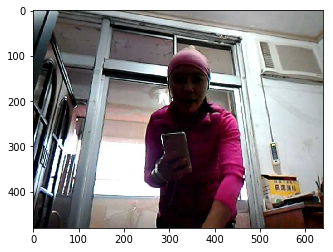

0 0.12975848


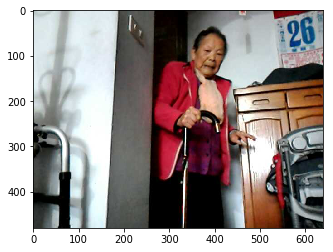

13539 0.1251306


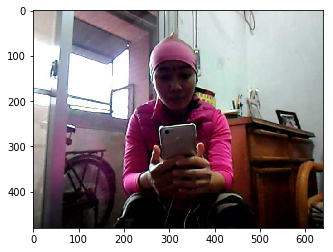

19970 0.112292945


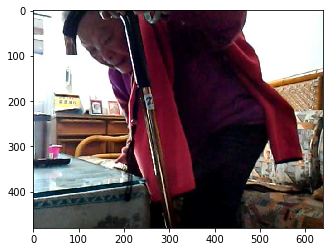

13375 0.1115224


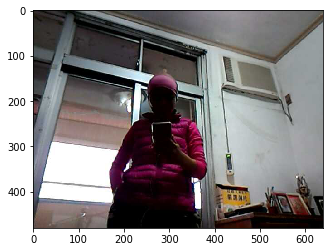

12624 0.11044143


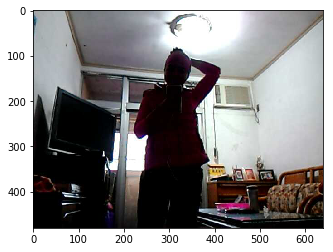

13261 0.10741361


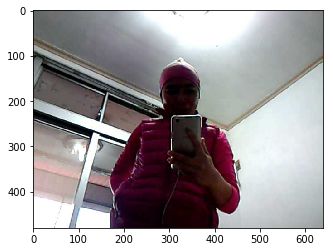

13158 0.10586173


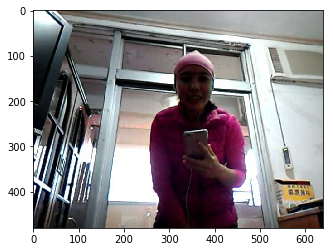

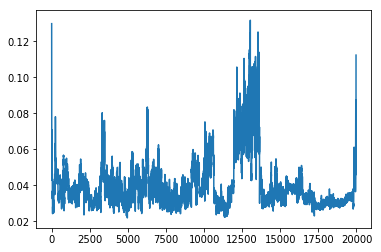

Finished. Total elapsed time (h:m:s): 0:11:27
Model saved to /4t/yangchihyuan/TransmittedImages/log/1226/model_epoch600.pth.tar


In [13]:
#Method 6: DSN, but modified
%reset
from __future__ import print_function
import os
import os.path as osp
import argparse
import sys
import h5py
import time
import datetime
import numpy as np
from tabulate import tabulate

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
from torch.distributions import Bernoulli

from utils import Logger, read_json, write_json, save_checkpoint
from models import *
from rewards import compute_reward
import vsum_tools
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
from shutil import copyfile

args_data_name="1226"
args_dataset='/4t/yangchihyuan/TransmittedImages/datasets/'+args_data_name+'_effective_GoogLeNet.h5'
args_image_directory="/4t/yangchihyuan/TransmittedImages/"+args_data_name
args_copy_to_directory="/4t/yangchihyuan/TransmittedImages/keyframes/method6_DSN/"+args_data_name
args_save_dir='/4t/yangchihyuan/TransmittedImages/log/'+args_data_name

# Model options
args_input_dim=1024
args_hidden_dim=256
args_num_layers=1
args_rnn_cell='lstm'
# Optimization options
args_lr=1e-05
args_weight_decay=1e-05
args_max_epoch=600
args_stepsize=30
args_gamma=0.1
args_num_episode=1
args_beta=0.01   #the weight of cost #default 0.01
# Misc
args_seed=1
args_gpu='0'
args_use_cpu=False
args_resume=''
args_verbose=True
args_save_results=True

torch.manual_seed(args_seed)
os.environ['CUDA_VISIBLE_DEVICES'] = args_gpu
use_gpu = torch.cuda.is_available()

#sys.stdout = Logger(osp.join(args_save_dir, 'log_train.txt'))

if use_gpu:
    print("Currently using GPU {}".format(args_gpu))
    cudnn.benchmark = True
    torch.cuda.manual_seed_all(args_seed)
else:
    print("Currently using CPU")

print("Initialize dataset {}".format(args_dataset))
dataset = h5py.File(args_dataset, 'r')
number_of_images = int(dataset[args_data_name]['n_frames'][...])   #the original type is 1x1 ndarray
file_list = dataset[args_data_name]['file_list'][...]
train_keys=[args_data_name]

print("Initialize model")
model = DSN(in_dim=args_input_dim, hid_dim=args_hidden_dim, num_layers=args_num_layers, cell=args_rnn_cell)
print("Model size: {:.5f}M".format(sum(p.numel() for p in model.parameters())/1000000.0))

optimizer = torch.optim.Adam(model.parameters(), lr=args_lr, weight_decay=args_weight_decay)
if args_stepsize > 0:
    scheduler = lr_scheduler.StepLR(optimizer, step_size=args_stepsize, gamma=args_gamma)

if args_resume:
    print("Loading checkpoint from '{}'".format(args_resume))
    checkpoint = torch.load(args_resume)
    model.load_state_dict(checkpoint)
else:
    start_epoch = 0
    

if use_gpu:
    model = nn.DataParallel(model).cuda()

print("==> Start training")
start_time = time.time()
model.train()
baselines = {key: 0. for key in train_keys} # baseline rewards for videos
#This is a dict
#reward_writers = {key: [] for key in train_keys} # record reward changes for each video
#This is also a dict

#for epoch in range(start_epoch, args_max_epoch):
#    idxs = np.arange(len(train_keys))   #train_keys is a list of video name
#    np.random.shuffle(idxs) # shuffle indices

#    for idx in idxs:
key = train_keys[0]
seq = dataset[key]['features'][...] # sequence of features, (seq_len, dim)
seq = torch.from_numpy(seq).unsqueeze(0) # input shape (1, seq_len, dim)
if use_gpu: seq = seq.cuda()
    
for epoch in range(start_epoch, args_max_epoch):
    probs = model(seq) # output shape (1, seq_len, 1)

    #cost is a torch.Tensor
    #cost = args_beta * (probs.mean() - 0.5)**2 # minimize summary length penalty term [Eq.11]
    cost = args_beta * (probs.mean() - 8.0/number_of_images)**2 # minimize summary length penalty term [Eq.11]
    #0.5 means the percentage of frames to be selected.
    #in my case. it is 
    m = Bernoulli(probs) #Bernoulli model
    epis_rewards = []
    for _ in range(args_num_episode):   #default value as 5
        actions = m.sample()      #This is a cuda tensor, cannot be detach()
        log_probs = m.log_prob(actions)   #construct a loss function
        reward = compute_reward(seq, actions, use_gpu=use_gpu)
        expected_reward = log_probs.mean() * (reward - baselines[key])  #What is the meaning of the baselines?
        cost -= expected_reward # minimize negative expected reward
#        cost -= reward
        epis_rewards.append(reward.item())
        
#    print('cost',cost)
    optimizer.zero_grad()
    cost.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)   
    optimizer.step() #update the model
    baselines[key] = 0.9 * baselines[key] + 0.1 * np.mean(epis_rewards) # update baseline reward via moving average
#    print('baselines[key]',baselines[key]) #it increases
#    reward_writers[key].append(np.mean(epis_rewards))  #it is the mean of epis_rewards
#    print('len(reward_writers[key])',len(reward_writers[key]))

#    epoch_reward = np.mean([reward_writers[key][epoch] for key in train_keys])
    print("epoch {}/{}\t cost {}\t reward {}\t".format(epoch+1, args_max_epoch, cost, np.mean(epis_rewards)))

probs = torch.Tensor.cpu(probs)
probs_np = probs.detach().numpy()[0]
probs_np_1d = probs_np.ravel()

#Select peak scores and suppress local values
sorted_arg = np.argsort(probs_np_1d)
sorted_arg_descend = sorted_arg[::-1]
available_list = [True] * number_of_images
selected_idx_list = []
for idx in sorted_arg_descend:
    if available_list[idx] == True:
        selected_idx_list.append(idx)
        available_list[idx] = False
#        print('Selected', idx, probs_np_1d[idx])
        if len(selected_idx_list) == 8:
            break
        step = 0
        while idx+step+1 < number_of_images:
            if step < 100:
                available_list[idx+step+1] = False
                step = step + 1
            else:
                break
        step = 0
        while idx-step-1 >=0:
            if step < 100:
                available_list[idx-step-1] = False
                step = step + 1
            else:
                break

#check whether copy_to_directory exists
if( os.path.exists(args_copy_to_directory) == False):
    os.makedirs(args_copy_to_directory)
else:
    #remove old files
    os.system("rm " + args_copy_to_directory +"/*")
    
for idx in selected_idx_list:
    print(idx, probs_np_1d[idx])
    file_name = file_list[idx]
    img=mpimg.imread(os.path.join(args_image_directory,file_name))
    imgplot = plt.imshow(img)        
    plt.show()
    copyfile(os.path.join(args_image_directory,file_name), os.path.join(args_copy_to_directory,file_name))

plt.figure()
plt.plot(probs_np_1d )
plt.show()

#write_json(reward_writers, osp.join(args_save_dir, 'rewards.json'))
#    evaluate(model, dataset, test_keys, use_gpu)

elapsed = round(time.time() - start_time)
elapsed = str(datetime.timedelta(seconds=elapsed))
print("Finished. Total elapsed time (h:m:s): {}".format(elapsed))

model_state_dict = model.module.state_dict() if use_gpu else model.state_dict()
model_save_path = osp.join(args_save_dir, 'model_epoch' + str(args_max_epoch) + '.pth.tar')
save_checkpoint(model_state_dict, model_save_path)
print("Model saved to {}".format(model_save_path))

dataset.close()


In [22]:
#Extract 1: GoogLeNet features
#The pretrainedmodels module does not require GPU memory
%reset
import os
import argparse
import sys
import h5py
import numpy as np
import torch

import pretrainedmodels
from pretrainedmodels import utils

args_video_name='0419_lab'
args_dataset='/4t/yangchihyuan/TransmittedImages/datasets/'+args_video_name+'_effective_GoogLeNet.h5'
args_listfile='/4t/yangchihyuan/TransmittedImages/filelist/'+args_video_name+'_effective.txt'
args_image_directory='/4t/yangchihyuan/TransmittedImages/'+args_video_name

model_name = 'bninception'
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
model.eval()
model.last_linear = utils.Identity()    
tf_img = utils.TransformImage(model)
load_img = utils.LoadImage()

with open(args_listfile ,'r') as f:
    file_list = f.readlines()
file_list = [x.strip() for x in file_list] #remove \n
number_of_image = len(file_list)

feature_matrix = np.empty((number_of_image, 1024), dtype=np.float32)
idx = 0
file_list_used = []
for file_name in file_list:
    try:
        input_img = load_img(os.path.join(args_image_directory, file_name))
        input_tensor = tf_img(input_img) 
        input_tensor = input_tensor.unsqueeze(0)
        input = torch.autograd.Variable(input_tensor,requires_grad=False)
        feature = model(input)
        feature_matrix[idx,:] = feature.detach().numpy()
        idx = idx + 1
        file_list_used.append(file_name)
    except:
        print('JPEG file corrupted', args_video_name,idx,file_name)

feature_matrix=feature_matrix[0:idx,:]

f = h5py.File(args_dataset, 'w')
f.create_dataset(args_video_name + '/features', data=feature_matrix)
f.create_dataset(args_video_name + '/n_frames', data=idx)
f.create_dataset(args_video_name + '/video_name', data=args_video_name)
f.create_dataset(args_video_name + '/file_list', data=file_list_used)
f.close()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [23]:
#Extract 2:Charades probability.
#This cell has to run in the container of robot because it require tensorflow.
#It uses the full GPU memory and runs very fast
%reset
import os
import cv2
import argparse
import sys
import h5py
import numpy as np
import tensorflow as tf

args_data_name="0419_lab"
args_dataset="/4t/yangchihyuan/TransmittedImages/datasets/"+args_data_name+"_effective_Charade.h5"
args_image_directory="/4t/yangchihyuan/TransmittedImages/"+args_data_name
args_listfile="/4t/yangchihyuan/TransmittedImages/filelist/"+args_data_name+"_effective.txt"
args_model="/4t/yangchihyuan/TransmittedImages/CharadesWebcam/frozen_model.pb"
args_labels="/4t/yangchihyuan/TransmittedImages/CharadesWebcam/labels.txt"


def loadlabels():
    # List of the strings that is used to add correct label for each box.
    labels = {}
    with open(args_labels) as f:
        for line in f:
            x = line.split(' ')
            cls, rest = x[0], ' '.join(x[1:]).strip()
            clsint = int(cls[1:])
            labels[clsint] = {'id': clsint, 'name': rest}
    return labels
category_index = loadlabels()


def prepare_im(image_np):
    # Normalize image and fix dimensions
    image_np = cv2.resize(image_np, dsize=(224,224)).astype(np.float32)/255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = (image_np-mean)/std
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    return image_np_expanded
    
    
def recognize_activity(image_np, sess, detection_graph):
    image_np_expanded = prepare_im(image_np)
    image_tensor = detection_graph.get_tensor_by_name('input_image:0')
    classes = detection_graph.get_tensor_by_name('classifier/Reshape:0')

    # Actual detection.
    (classes) = sess.run(
        [classes],
        feed_dict={image_tensor: image_np_expanded})
    
    classes = np.exp(np.squeeze(classes))
    classes = classes / np.sum(classes)    #classes means the probability
    return classes

print('enter main')
with open(args_listfile ,'r') as f:
    file_list = f.readlines()
file_list = [x.strip() for x in file_list] #remove \n
number_of_image = len(file_list)

#load tensorflow
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(args_model, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)


feature_matrix = np.empty((number_of_image, 157), dtype=np.float32)
idx = 0
file_list_used = []
for file_name in file_list:
    print(args_data_name,idx,file_name)
    input_img = cv2.imread(os.path.join(args_image_directory, file_name))
    probability_array = recognize_activity(input_img, sess, detection_graph)
    feature_matrix[idx,:] = probability_array
    idx = idx + 1
    file_list_used.append(file_name)

sess.close()


f = h5py.File(args_dataset, 'w')
f.create_dataset(args_data_name + '/features', data=feature_matrix)
f.create_dataset(args_data_name + '/n_frames', data=idx)
f.create_dataset(args_data_name + '/data_name', data=args_data_name)
f.create_dataset(args_data_name + '/file_list', data=file_list_used)
f.close()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
enter main
('0419_lab', 0, '1555655099250.jpg')
('0419_lab', 1, '1555655099363.jpg')
('0419_lab', 2, '1555655099499.jpg')
('0419_lab', 3, '1555655099629.jpg')
('0419_lab', 4, '1555655099732.jpg')
('0419_lab', 5, '1555655099864.jpg')
('0419_lab', 6, '1555655099994.jpg')
('0419_lab', 7, '1555655100099.jpg')
('0419_lab', 8, '1555655100228.jpg')
('0419_lab', 9, '1555655100330.jpg')
('0419_lab', 10, '1555655100465.jpg')
('0419_lab', 11, '1555655100594.jpg')
('0419_lab', 12, '1555655100727.jpg')
('0419_lab', 13, '1555655100828.jpg')
('0419_lab', 14, '1555655103063.jpg')
('0419_lab', 15, '1555655103194.jpg')
('0419_lab', 16, '1555655103325.jpg')
('0419_lab', 17, '1555655103427.jpg')
('0419_lab', 18, '1555655103532.jpg')
('0419_lab', 19, '1555655103666.jpg')
('0419_lab', 20, '1555655103793.jpg')
('0419_lab', 21, '1555655103926.jpg')
('0419_lab', 22, '1555655104063.jpg')
('0419_lab', 23, '1555655104194.jpg')
('0419_lab', 24, '15556

('0419_lab', 227, '1555655936534.jpg')
('0419_lab', 228, '1555655936767.jpg')
('0419_lab', 229, '1555655936899.jpg')
('0419_lab', 230, '1555655937034.jpg')
('0419_lab', 231, '1555655943531.jpg')
('0419_lab', 232, '1555655943632.jpg')
('0419_lab', 233, '1555655943766.jpg')
('0419_lab', 234, '1555655943899.jpg')
('0419_lab', 235, '1555655944030.jpg')
('0419_lab', 236, '1555655944131.jpg')
('0419_lab', 237, '1555655950164.jpg')
('0419_lab', 238, '1555655950510.jpg')
('0419_lab', 239, '1555655950643.jpg')
('0419_lab', 240, '1555655950763.jpg')
('0419_lab', 241, '1555655950875.jpg')
('0419_lab', 242, '1555655951100.jpg')
('0419_lab', 243, '1555655951235.jpg')
('0419_lab', 244, '1555655951361.jpg')
('0419_lab', 245, '1555655951595.jpg')
('0419_lab', 246, '1555655951735.jpg')
('0419_lab', 247, '1555655951861.jpg')
('0419_lab', 248, '1555655951963.jpg')
('0419_lab', 249, '1555655952098.jpg')
('0419_lab', 250, '1555655952229.jpg')
('0419_lab', 251, '1555655952337.jpg')
('0419_lab', 252, '155565

('0419_lab', 439, '1555656121417.jpg')
('0419_lab', 440, '1555656121647.jpg')
('0419_lab', 441, '1555656133045.jpg')
('0419_lab', 442, '1555656134845.jpg')
('0419_lab', 443, '1555656134984.jpg')
('0419_lab', 444, '1555656135085.jpg')
('0419_lab', 445, '1555656135312.jpg')
('0419_lab', 446, '1555656135414.jpg')
('0419_lab', 447, '1555656135544.jpg')
('0419_lab', 448, '1555656135646.jpg')
('0419_lab', 449, '1555656135778.jpg')
('0419_lab', 450, '1555656135909.jpg')
('0419_lab', 451, '1555656136015.jpg')
('0419_lab', 452, '1555656136119.jpg')
('0419_lab', 453, '1555656136347.jpg')
('0419_lab', 454, '1555656136451.jpg')
('0419_lab', 455, '1555656136591.jpg')
('0419_lab', 456, '1555656136715.jpg')
('0419_lab', 457, '1555656136827.jpg')
('0419_lab', 458, '1555656137051.jpg')
('0419_lab', 459, '1555656137181.jpg')
('0419_lab', 460, '1555656137282.jpg')
('0419_lab', 461, '1555656137413.jpg')
('0419_lab', 462, '1555656137542.jpg')
('0419_lab', 463, '1555656137651.jpg')
('0419_lab', 464, '155565

('0419_lab', 667, '1555657889487.jpg')
('0419_lab', 668, '1555657889629.jpg')
('0419_lab', 669, '1555657889737.jpg')
('0419_lab', 670, '1555657900836.jpg')
('0419_lab', 671, '1555657904201.jpg')
('0419_lab', 672, '1555657904335.jpg')
('0419_lab', 673, '1555657904467.jpg')
('0419_lab', 674, '1555657904703.jpg')
('0419_lab', 675, '1555657905102.jpg')
('0419_lab', 676, '1555657905442.jpg')
('0419_lab', 677, '1555657905567.jpg')
('0419_lab', 678, '1555657905806.jpg')
('0419_lab', 679, '1555657905908.jpg')
('0419_lab', 680, '1555657906010.jpg')
('0419_lab', 681, '1555657906266.jpg')
('0419_lab', 682, '1555657906407.jpg')
('0419_lab', 683, '1555657906534.jpg')
('0419_lab', 684, '1555657906770.jpg')
('0419_lab', 685, '1555657907005.jpg')
('0419_lab', 686, '1555657907106.jpg')
('0419_lab', 687, '1555657907235.jpg')
('0419_lab', 688, '1555657907336.jpg')
('0419_lab', 689, '1555657907469.jpg')
('0419_lab', 690, '1555657907605.jpg')
('0419_lab', 691, '1555657907734.jpg')
('0419_lab', 692, '155565

('0419_lab', 893, '1555658714131.jpg')
('0419_lab', 894, '1555658714336.jpg')
('0419_lab', 895, '1555658714901.jpg')
('0419_lab', 896, '1555658715242.jpg')
('0419_lab', 897, '1555658715368.jpg')
('0419_lab', 898, '1555658715598.jpg')
('0419_lab', 899, '1555658715699.jpg')
('0419_lab', 900, '1555658729667.jpg')
('0419_lab', 901, '1555658729827.jpg')
('0419_lab', 902, '1555658737593.jpg')
('0419_lab', 903, '1555658737834.jpg')
('0419_lab', 904, '1555658738168.jpg')
('0419_lab', 905, '1555658749359.jpg')
('0419_lab', 906, '1555658758656.jpg')
('0419_lab', 907, '1555658758785.jpg')
('0419_lab', 908, '1555658759118.jpg')
('0419_lab', 909, '1555658759591.jpg')
('0419_lab', 910, '1555658759718.jpg')
('0419_lab', 911, '1555658759924.jpg')
('0419_lab', 912, '1555658760056.jpg')
('0419_lab', 913, '1555658769848.jpg')
('0419_lab', 914, '1555658770083.jpg')
('0419_lab', 915, '1555658770214.jpg')
('0419_lab', 916, '1555658770447.jpg')
('0419_lab', 917, '1555658770683.jpg')
('0419_lab', 918, '155565

('0419_lab', 1109, '1555660128920.jpg')
('0419_lab', 1110, '1555660129152.jpg')
('0419_lab', 1111, '1555660129387.jpg')
('0419_lab', 1112, '1555660130794.jpg')
('0419_lab', 1113, '1555660131186.jpg')
('0419_lab', 1114, '1555660131416.jpg')
('0419_lab', 1115, '1555660267228.jpg')
('0419_lab', 1116, '1555660267342.jpg')
('0419_lab', 1117, '1555660267577.jpg')
('0419_lab', 1118, '1555660267682.jpg')
('0419_lab', 1119, '1555660267941.jpg')
('0419_lab', 1120, '1555660268051.jpg')
('0419_lab', 1121, '1555660268257.jpg')
('0419_lab', 1122, '1555660284101.jpg')
('0419_lab', 1123, '1555660291333.jpg')
('0419_lab', 1124, '1555660291439.jpg')
('0419_lab', 1125, '1555660291674.jpg')
('0419_lab', 1126, '1555660292045.jpg')
('0419_lab', 1127, '1555660292305.jpg')
('0419_lab', 1128, '1555660292570.jpg')
('0419_lab', 1129, '1555660292974.jpg')
('0419_lab', 1130, '1555660293098.jpg')
('0419_lab', 1131, '1555660296965.jpg')
('0419_lab', 1132, '1555660297200.jpg')
('0419_lab', 1133, '1555660297436.jpg')


('0419_lab', 1322, '1555661193824.jpg')
('0419_lab', 1323, '1555661194057.jpg')
('0419_lab', 1324, '1555661194191.jpg')
('0419_lab', 1325, '1555661194325.jpg')
('0419_lab', 1326, '1555661194459.jpg')
('0419_lab', 1327, '1555661194590.jpg')
('0419_lab', 1328, '1555661194722.jpg')
('0419_lab', 1329, '1555661194859.jpg')
('0419_lab', 1330, '1555661194994.jpg')
('0419_lab', 1331, '1555661195125.jpg')
('0419_lab', 1332, '1555661195258.jpg')
('0419_lab', 1333, '1555661195390.jpg')
('0419_lab', 1334, '1555661195523.jpg')
('0419_lab', 1335, '1555661195624.jpg')
('0419_lab', 1336, '1555661195725.jpg')
('0419_lab', 1337, '1555661195856.jpg')
('0419_lab', 1338, '1555661195990.jpg')
('0419_lab', 1339, '1555661196121.jpg')
('0419_lab', 1340, '1555661196323.jpg')
('0419_lab', 1341, '1555661196426.jpg')
('0419_lab', 1342, '1555661196556.jpg')
('0419_lab', 1343, '1555661196688.jpg')
('0419_lab', 1344, '1555661196789.jpg')
('0419_lab', 1345, '1555661196922.jpg')
('0419_lab', 1346, '1555661197054.jpg')


('0419_lab', 1540, '1555661939013.jpg')
('0419_lab', 1541, '1555661939140.jpg')
('0419_lab', 1542, '1555661939270.jpg')
('0419_lab', 1543, '1555661939372.jpg')
('0419_lab', 1544, '1555661939604.jpg')
('0419_lab', 1545, '1555661939837.jpg')
('0419_lab', 1546, '1555661939949.jpg')
('0419_lab', 1547, '1555661940210.jpg')
('0419_lab', 1548, '1555661940337.jpg')
('0419_lab', 1549, '1555661940673.jpg')
('0419_lab', 1550, '1555661940980.jpg')
('0419_lab', 1551, '1555661941102.jpg')
('0419_lab', 1552, '1555661941451.jpg')
('0419_lab', 1553, '1555661941677.jpg')
('0419_lab', 1554, '1555661992955.jpg')
('0419_lab', 1555, '1555661993389.jpg')
('0419_lab', 1556, '1555661993493.jpg')
('0419_lab', 1557, '1555661993596.jpg')
('0419_lab', 1558, '1555661993697.jpg')
('0419_lab', 1559, '1555661993800.jpg')
('0419_lab', 1560, '1555661994056.jpg')
('0419_lab', 1561, '1555661994159.jpg')
('0419_lab', 1562, '1555661994289.jpg')
('0419_lab', 1563, '1555662002850.jpg')
('0419_lab', 1564, '1555662002983.jpg')


('0419_lab', 1758, '1555662334729.jpg')
('0419_lab', 1759, '1555662334952.jpg')
('0419_lab', 1760, '1555662335184.jpg')
('0419_lab', 1761, '1555662335442.jpg')
('0419_lab', 1762, '1555662335564.jpg')
('0419_lab', 1763, '1555662335685.jpg')
('0419_lab', 1764, '1555662335944.jpg')
('0419_lab', 1765, '1555662338412.jpg')
('0419_lab', 1766, '1555662338646.jpg')
('0419_lab', 1767, '1555662338880.jpg')
('0419_lab', 1768, '1555662339083.jpg')
('0419_lab', 1769, '1555662339211.jpg')
('0419_lab', 1770, '1555662384231.jpg')
('0419_lab', 1771, '1555662384465.jpg')
('0419_lab', 1772, '1555662384866.jpg')
('0419_lab', 1773, '1555662385267.jpg')
('0419_lab', 1774, '1555662385772.jpg')
('0419_lab', 1775, '1555662389330.jpg')
('0419_lab', 1776, '1555662389595.jpg')
('0419_lab', 1777, '1555662389702.jpg')
('0419_lab', 1778, '1555662389933.jpg')
('0419_lab', 1779, '1555662390068.jpg')
('0419_lab', 1780, '1555662390306.jpg')
('0419_lab', 1781, '1555662390408.jpg')
('0419_lab', 1782, '1555662394469.jpg')


('0419_lab', 1973, '1555663138901.jpg')
('0419_lab', 1974, '1555663139004.jpg')
('0419_lab', 1975, '1555663139235.jpg')
('0419_lab', 1976, '1555663139340.jpg')
('0419_lab', 1977, '1555663139738.jpg')
('0419_lab', 1978, '1555663139867.jpg')
('0419_lab', 1979, '1555663265935.jpg')
('0419_lab', 1980, '1555663266143.jpg')
('0419_lab', 1981, '1555663266279.jpg')
('0419_lab', 1982, '1555663266568.jpg')
('0419_lab', 1983, '1555663266803.jpg')
('0419_lab', 1984, '1555663267009.jpg')
('0419_lab', 1985, '1555663267244.jpg')
('0419_lab', 1986, '1555663267374.jpg')
('0419_lab', 1987, '1555663267576.jpg')
('0419_lab', 1988, '1555663268069.jpg')
('0419_lab', 1989, '1555663268280.jpg')
('0419_lab', 1990, '1555663268402.jpg')
('0419_lab', 1991, '1555663286764.jpg')
('0419_lab', 1992, '1555663286998.jpg')
('0419_lab', 1993, '1555663288263.jpg')
('0419_lab', 1994, '1555663288663.jpg')
('0419_lab', 1995, '1555663289897.jpg')
('0419_lab', 1996, '1555663290129.jpg')
('0419_lab', 1997, '1555663291660.jpg')


('0419_lab', 2191, '1555663587977.jpg')
('0419_lab', 2192, '1555663588213.jpg')
('0419_lab', 2193, '1555663588344.jpg')
('0419_lab', 2194, '1555663588445.jpg')
('0419_lab', 2195, '1555663588677.jpg')
('0419_lab', 2196, '1555663588778.jpg')
('0419_lab', 2197, '1555663589011.jpg')
('0419_lab', 2198, '1555663589112.jpg')
('0419_lab', 2199, '1555663589377.jpg')
('0419_lab', 2200, '1555663589510.jpg')
('0419_lab', 2201, '1555663589779.jpg')
('0419_lab', 2202, '1555663589912.jpg')
('0419_lab', 2203, '1555663590043.jpg')
('0419_lab', 2204, '1555663590177.jpg')
('0419_lab', 2205, '1555663590279.jpg')
('0419_lab', 2206, '1555663590513.jpg')
('0419_lab', 2207, '1555663590643.jpg')
('0419_lab', 2208, '1555663590744.jpg')
('0419_lab', 2209, '1555663590877.jpg')
('0419_lab', 2210, '1555663591011.jpg')
('0419_lab', 2211, '1555663591147.jpg')
('0419_lab', 2212, '1555663591278.jpg')
('0419_lab', 2213, '1555663591516.jpg')
('0419_lab', 2214, '1555663591643.jpg')
('0419_lab', 2215, '1555663591878.jpg')


('0419_lab', 2412, '1555663627970.jpg')
('0419_lab', 2413, '1555663628072.jpg')
('0419_lab', 2414, '1555663628206.jpg')
('0419_lab', 2415, '1555663628538.jpg')
('0419_lab', 2416, '1555663628668.jpg')
('0419_lab', 2417, '1555663628800.jpg')
('0419_lab', 2418, '1555663629403.jpg')
('0419_lab', 2419, '1555663629635.jpg')
('0419_lab', 2420, '1555663629767.jpg')
('0419_lab', 2421, '1555663630038.jpg')
('0419_lab', 2422, '1555663630171.jpg')
('0419_lab', 2423, '1555663630305.jpg')
('0419_lab', 2424, '1555663630433.jpg')
('0419_lab', 2425, '1555663630666.jpg')
('0419_lab', 2426, '1555663630901.jpg')
('0419_lab', 2427, '1555663631168.jpg')
('0419_lab', 2428, '1555663631305.jpg')
('0419_lab', 2429, '1555663631434.jpg')
('0419_lab', 2430, '1555663631702.jpg')
('0419_lab', 2431, '1555663631969.jpg')
('0419_lab', 2432, '1555663632233.jpg')
('0419_lab', 2433, '1555663632367.jpg')
('0419_lab', 2434, '1555663636367.jpg')
('0419_lab', 2435, '1555663636501.jpg')
('0419_lab', 2436, '1555663636632.jpg')


('0419_lab', 2630, '1555664105338.jpg')
('0419_lab', 2631, '1555664105597.jpg')
('0419_lab', 2632, '1555664105830.jpg')
('0419_lab', 2633, '1555664106036.jpg')
('0419_lab', 2634, '1555664106299.jpg')
('0419_lab', 2635, '1555664106531.jpg')
('0419_lab', 2636, '1555664106764.jpg')
('0419_lab', 2637, '1555664107029.jpg')
('0419_lab', 2638, '1555664107231.jpg')
('0419_lab', 2639, '1555664107498.jpg')
('0419_lab', 2640, '1555664107630.jpg')
('0419_lab', 2641, '1555664108001.jpg')
('0419_lab', 2642, '1555664108262.jpg')
('0419_lab', 2643, '1555664108530.jpg')
('0419_lab', 2644, '1555664108734.jpg')
('0419_lab', 2645, '1555664108996.jpg')
('0419_lab', 2646, '1555664109099.jpg')
('0419_lab', 2647, '1555664109362.jpg')
('0419_lab', 2648, '1555664109696.jpg')
('0419_lab', 2649, '1555664109963.jpg')
('0419_lab', 2650, '1555664110364.jpg')
('0419_lab', 2651, '1555664110596.jpg')
('0419_lab', 2652, '1555664110799.jpg')
('0419_lab', 2653, '1555664111061.jpg')
('0419_lab', 2654, '1555664111331.jpg')


('0419_lab', 2836, '1555664158615.jpg')
('0419_lab', 2837, '1555664158882.jpg')
('0419_lab', 2838, '1555664159148.jpg')
('0419_lab', 2839, '1555664159249.jpg')
('0419_lab', 2840, '1555664159581.jpg')
('0419_lab', 2841, '1555664159820.jpg')
('0419_lab', 2842, '1555664160087.jpg')
('0419_lab', 2843, '1555664160350.jpg')
('0419_lab', 2844, '1555664160451.jpg')
('0419_lab', 2845, '1555664160714.jpg')
('0419_lab', 2846, '1555664161083.jpg')
('0419_lab', 2847, '1555664161214.jpg')
('0419_lab', 2848, '1555664161586.jpg')
('0419_lab', 2849, '1555664161851.jpg')
('0419_lab', 2850, '1555664162247.jpg')
('0419_lab', 2851, '1555664162450.jpg')
('0419_lab', 2852, '1555664162584.jpg')
('0419_lab', 2853, '1555664162917.jpg')
('0419_lab', 2854, '1555664163151.jpg')
('0419_lab', 2855, '1555664163382.jpg')
('0419_lab', 2856, '1555664163585.jpg')
('0419_lab', 2857, '1555664163848.jpg')
('0419_lab', 2858, '1555664164083.jpg')
('0419_lab', 2859, '1555664164346.jpg')
('0419_lab', 2860, '1555664164582.jpg')


('0419_lab', 3057, '1555664209805.jpg')
('0419_lab', 3058, '1555664209936.jpg')
('0419_lab', 3059, '1555664210067.jpg')
('0419_lab', 3060, '1555664210303.jpg')
('0419_lab', 3061, '1555664210566.jpg')
('0419_lab', 3062, '1555664210702.jpg')
('0419_lab', 3063, '1555664210804.jpg')
('0419_lab', 3064, '1555664210940.jpg')
('0419_lab', 3065, '1555664211201.jpg')
('0419_lab', 3066, '1555664211333.jpg')
('0419_lab', 3067, '1555664211799.jpg')
('0419_lab', 3068, '1555664211940.jpg')
('0419_lab', 3069, '1555664212070.jpg')
('0419_lab', 3070, '1555664212206.jpg')
('0419_lab', 3071, '1555664212332.jpg')
('0419_lab', 3072, '1555664212434.jpg')
('0419_lab', 3073, '1555664212703.jpg')
('0419_lab', 3074, '1555664212934.jpg')
('0419_lab', 3075, '1555664213069.jpg')
('0419_lab', 3076, '1555664213305.jpg')
('0419_lab', 3077, '1555664213432.jpg')
('0419_lab', 3078, '1555664213804.jpg')
('0419_lab', 3079, '1555664213905.jpg')
('0419_lab', 3080, '1555664231095.jpg')
('0419_lab', 3081, '1555664231228.jpg')


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
['19:19', '20:28', '21:36', '22:44', '23:53']
1
0
1
0
1
0
1
0
1
0
1
0
[1545996701504, 1545997444522, 1545997663199, 1546000779062, 1546001008228, 1546002033693, 1546004744872, 1546004849269]
[1545997366802, 1545997421208, 1545997640501, 1545997699126, 1546000768076, 1546001092502, 1546001103869, 1546004784319]
[1545995983803, 1545996651622, 1545996693573, 1545997263613, 1546000513011, 1546003407379, 1546006157281, 1546012391159]
[1545996684227, 1545997366334, 1546000873843, 1546002069589, 1546003624485, 1546004741669, 1546006165820, 1546008538533]


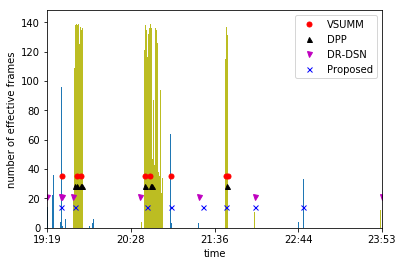

In [5]:
#Utility 1
#Draw a histogram chart, but show different colors for different segments
%reset
import os
from datetime import datetime
import subprocess
import matplotlib.pyplot as plt
import math
import json
import h5py
import numpy as np
import pytz
taipei_timezone = pytz.timezone('Asia/Taipei')

args_data_name="1228"
args_dataset="/4t/yangchihyuan/TransmittedImages/datasets/"+args_data_name+"_effective_GoogLeNet.h5"
args_keyframes_directory=["/4t/yangchihyuan/TransmittedImages/keyframes/method5_VSUMM/"+args_data_name,
"/4t/yangchihyuan/TransmittedImages/keyframes/method4_dpp/"+args_data_name,
"/4t/yangchihyuan/TransmittedImages/keyframes/method6_DSN/"+args_data_name,
"/4t/yangchihyuan/TransmittedImages/keyframes/method3_time_action/"+args_data_name]
#args_keyframes_directory=["/4t/yangchihyuan/TransmittedImages/keyframes/method3_time_action/"+args_data_name]
args_figure_size=(6,4)  #for paper
args_figure_name_eps="/4t/yangchihyuan/TransmittedImages/chart/"+args_data_name+".eps"
args_figure_name_png="/4t/yangchihyuan/TransmittedImages/chart/"+args_data_name+".png"
args_load_segments_file="/4t/yangchihyuan/TransmittedImages/clusters/method3_time_action/"+args_data_name+".json"

dataset = h5py.File(args_dataset, 'r')
file_list = dataset[args_data_name]['file_list'][...]

timestamps = []
for filename in file_list:
    timestamps.append( int(filename[:-4]))
    
timestamp_begin = timestamps[0]
timestamp_end = timestamps[-1]
timestamp_array = np.linspace(timestamp_begin, timestamp_end, 5)
time_string_array = []
for timestamp in timestamp_array:
    value = datetime.fromtimestamp(timestamp/1000, taipei_timezone)       #the default is Greenwish time. I need to control timezone
    time_string_array.append(value.strftime('%H:%M'))

print(time_string_array)

plt.figure(figsize = args_figure_size)
duration = timestamp_end - timestamp_begin
duration_a_bin = duration / 1000
[n, bins, patches]= plt.hist(timestamps, 1000)
plt.close()
plt.figure(figsize = args_figure_size)
#load the segment result into a json file
with open(args_load_segments_file, 'r') as outfile:
    segments = json.load(outfile)
    
#I need segment data to select colors, 
color_list=['C0','C8']
color_idx = 0
for segment in segments:
    timestamp_head = timestamps[segment[0]]
    timestamp_tail = timestamps[segment[-1]]
    bin_head = int(math.floor( (timestamp_head - timestamp_begin)/duration_a_bin))
    bin_tail = int(math.ceil( (timestamp_tail - timestamp_begin)/duration_a_bin ))
    plt.bar(bins[bin_head:bin_tail],n[bin_head:bin_tail],width=bins[1]-bins[0],align='edge',color=color_list[color_idx])
    color_idx = (color_idx+1) % 2
    print(color_idx)
    
plt.axis([timestamp_begin, timestamp_end, None, None])

plt.xticks( timestamp_array, time_string_array )
plt.xlabel('time')
plt.ylabel('number of effective frames')

#get the list of selected frames
idx =0
#mark_list = ['cs','ro','k^','mv','bx']
mark_list = ['ro','k^','mv','bx']
y_max = max(n)
#print(y_max)
ratio_list = [0.25, 0.2, 0.15, 0.1, 0.05]
height_list = [i * y_max for i in ratio_list]
#print(height_list)
legends=['VSUMM','DPP','DR-DSN','Proposed']
for directory in args_keyframes_directory:
    #print(directory)
    output=subprocess.check_output(["ls", directory])
    #print(output) #this is a single string
    output_parse = output.split('\n')
    filelist = output_parse[:-1]   #ignore the last empty element
    #print("len", len(output))
    #print("len output_parse", len(output_parse))
    #print(output_parse)
    #print(filelist)
    timestamps_mark = []
    for filename in filelist:
        timestamps_mark.append( int(filename[:-4]))

    print(timestamps_mark)
    y = [height_list[idx]] * len(timestamps_mark)
    l = plt.plot(timestamps_mark,y, mark_list[idx])
    plt.setp(l, markersize=5)
    idx+=1
    
plt.legend(legends)    
plt.savefig(args_figure_name_eps,bbox_inches='tight',transparent=True, pad_inches=0)
plt.savefig(args_figure_name_png, dpi=72*10,bbox_inches='tight',transparent=True, pad_inches=0)
plt.show()

In [ ]:
#Preprocessing
#Filter for repeated and corrupt frames
%reset
import os
import cv2
import argparse
import sys
import numpy as np
from shutil import copyfile

# Dataset options
args_listfile="/4t/yangchihyuan/TransmittedImages/filelist/1226_test.txt"
args_image_directory="/4t/yangchihyuan/TransmittedImages/1226"
args_listfile_output="/4t/yangchihyuan/TransmittedImages/filelist/1226_test_output.txt"

with open(args_listfile ,'r') as f:
    file_list = f.readlines()
file_list = [x.strip() for x in file_list] #remove \n
number_of_image = len(file_list)

for idx in range(number_of_image):
    file_name = file_list[idx]
    print(idx,file_name)
    try:
        if idx==0:
         previous_img = cv2.imread(os.path.join(args.image_directory, file_name))
        else:
         previous_img = input_img

        input_img = cv2.imread(os.path.join(args.image_directory, file_name))
        #check the content of two images
        diff = previous_img - input_img
        nonzero_count = np.count_nonzero(diff)
#            print(nonzero_count)
        if nonzero_count == 0:
         print('repeat',file_list[idx-1],file_list[idx])
        else:
     copyfile(os.path.join(args.image_directory, file_name), os.path.join(args.output_image_directory, file_name))

    except KeyboardInterrupt:
        raise

In [ ]:
#Utility2
#for visual inspection
#Create subdirectories based on clusteres, and copy frames into those clusters
group_idx = 0
for timestamp_group in nested_list_timestamp:
    #create a directory
    dirName = os.path.join(args_copy_to_directory,'group'+str(group_idx))
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        print("Directory " , dirName ,  " already exists")

    #copy file
    for timestamp in timestamp_group:
        file_name = str(timestamp) + '.jpg'
        copyfile(os.path.join(args_image_directory,file_name), os.path.join(dirName,file_name))

    group_idx = group_idx + 1

In [ ]:
#find the most diverse images from those cluster centers
number_of_segments = len(averaged_feature_list)
cluster_features = np.empty((number_of_segments,157),dtype=np.float64)
idx = 0
for feature in averaged_feature_list:
    cluster_features[idx,:] = feature
number_of_images = feature_matrix.shape[0]
#min_norm_ndarray = np.empty((number_of_images,1),dtype=np.float64)
min_norm_list = []
for idx in range(0,number_of_images):
    feature = feature_matrix[idx,:]
    diff = cluster_features - np.tile(feature,(number_of_segments,1))
    square = diff * diff
    l2_norm = np.sqrt(np.sum(square,axis=1))
    min_norm = l2_norm.min()
    min_norm_list.append(min_norm)

#find the max value
#print(min_norm_list)
#print(len(min_norm_list))
index_global = np.argsort(min_norm_list)[-1]
#print(index)   #the max l2_norm
file_name = file_list[index_global]
img=mpimg.imread(os.path.join(args_image_directory,file_name))
plt.figure()
imgplot = plt.imshow(img)
copyfile(os.path.join(args_image_directory,file_name), os.path.join(args_copy_to_directory,file_name))

In [ ]:
#Method3-1, experiment with action similarity
#compute the mean of the features in each cluster. This is the representative set.
#sort the nested_list_timestamp by the numbers of frames contained in clusters
import os
import sys
import h5py
import numpy as np
from sklearn.cluster import KMeans
from shutil import copyfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

args_data_name="1226"
args_dataset="/4t/yangchihyuan/TransmittedImages/datasets/Zenbo_"+args_data_name+"_clear_Charade.h5"
args_image_directory="/4t/yangchihyuan/TransmittedImages/"+args_data_name
args_number_of_clusters=8
args_copy_to_directory="/4t/yangchihyuan/TransmittedImages/keyframes/method3_time_action/"+args_data_name

dataset = h5py.File(args_dataset, 'r')
feature_matrix = dataset[args_data_name]['features'][...]
file_list = dataset[args_data_name]['file_list'][...]
number_of_images = feature_matrix.shape[0]
print('number_of_images', number_of_images)

#convert the file_list into a list of timestamps
timestamps = []
idx = 0
for filename in file_list:
    timestamps.append( int(filename[:-4]))
    idx = idx +1

#print('index_group[0],timestamps[-1]',datetime.fromtimestamp(timestamps[index_group[0]]/1000).strftime('%H:%M'),datetime.fromtimestamp(timestamps[index_group[-1]]/1000).strftime('%H:%M'))
duration = timestamps[-1] - timestamps[0]
time_gap_threshold = 0.001 * duration   #the type is float, What will happen if I use a small gap? say 0.001?
print('time_gap_threshold',time_gap_threshold)

next_timestamp = timestamps[0]
segments = []
segment = [0]
for idx in range(1,number_of_images):
    previous_timestamp = next_timestamp
    next_timestamp = timestamps[idx]
    if next_timestamp - previous_timestamp < time_gap_threshold:
        segment.append(idx)
    else:
        segments.append(segment)
        segment = [idx]
segments.append(segment)   #add the last segment


bMerge = True
while bMerge:
    number_of_segments = len(segments)
    print('number of segments',number_of_segments)
    if number_of_segments == 8:
        break
    number_of_indices_list = [len(segment) for segment in segments]
    print('number of index in each segment',number_of_indices_list)
#    order_by_size = np.argsort(number_of_indices_list)[::-1]
#    print('order_by_size', order_by_size)
#    sorted_number_of_indices_list = np.sort(number_of_indices_list)[::-1]
#    print('sorted_number_of_images_list', sorted_number_of_indices_list)

    #consider segment merge if the two segments are highly similar in terms of actions and close to each other
    averaged_feature_list = []
    for segment in segments:
        number_of_images = len(segment_index)
        feature_sum = np.zeros((number_of_images,157), dtype=np.float32)
        feature_in_segment = feature_matrix[segment,:]
        averaged_feature = np.mean(feature_in_segment, axis=0)
        averaged_feature_list.append(averaged_feature)

    #draw the distance map
    distance_matrix = np.zeros((number_of_segments, number_of_segments), dtype=np.float32)
    for idx in range(0,number_of_segments):
        probability1 = averaged_feature_list[idx]
        for idx2 in range(idx+1,number_of_segments):
            probability2 = averaged_feature_list[idx2]
            #compute the distance
            distance_matrix[idx,idx2] = np.linalg.norm(probability1-probability2)
    plt.imshow(distance_matrix)
    plt.colorbar()
    plt.show()

    distance_list = []
    for idx in range(0,number_of_segments-1):
        distance_list.append(distance_matrix[idx,idx2])
    plt.plot(distance_list)
    plt.show()

    merge_threshold = 0.125
    #merge
    idx_smallest_distance = np.argsort(distance_list)[0]
    if distance_list[idx_smallest_distance] < merge_threshold:
        #print(len(segments[idx_smallest_distance]))
        #print(len(segments[idx_smallest_distance+1]))
        segments[idx_smallest_distance] = segments[idx_smallest_distance] + segments[idx_smallest_distance+1]
        del segments[idx_smallest_distance+1]
        #print(len(segments[idx_smallest_distance]))
    else:
        bMerge = False
        

#check whether copy_to_directory exists
if( os.path.exists(args_copy_to_directory) == False):
    os.mkdir(args_copy_to_directory)
else:
    #remove old files
    os.system("rm " + args_copy_to_directory +"/*")

for idx_segment in range(0,np.minimum(8,number_of_segments)):
    segment = segments[idx_segment]
    number_of_images = len(segment)
    feature_sum = np.zeros((number_of_images,157), dtype=np.float32)
    feature_in_cluster = feature_matrix[segment,:]
    averaged_feature = np.mean(feature_in_cluster, axis=0)
    averaged_feature_list.append(averaged_feature)
    diff = feature_in_cluster - np.tile(averaged_feature,(number_of_images,1))
    square = diff * diff
    l2_norm = np.sqrt(np.sum(square,axis=1))
    index_representative = np.argsort(l2_norm)[0]
    index_global = segment[index_representative]
    print('index_global', index_global)
    file_name = file_list[index_global]
    print('file_name', file_name)
    img=mpimg.imread(os.path.join(args_image_directory,file_name))
    plt.figure()
    imgplot = plt.imshow(img)
    copyfile(os.path.join(args_image_directory,file_name), os.path.join(args_copy_to_directory,file_name))


In [ ]:
#Open an h5py file, segment frames into clusters by time
#from __future__ import print_function
import os
#import os.path as osp
#import argparse
import sys
#import numpy as np
#import matplotlib.pyplot as plt
import h5py
from datetime import datetime
import errno

#from sklearn.cluster import KMeans
from shutil import copyfile

args_dataset="/4t/yangchihyuan/TransmittedImages/datasets/Zenbo_1228_clear_Charade.h5"
args_data_name="1228"
#args_image_directory="/4t/yangchihyuan/TransmittedImages/1225"

dataset = h5py.File(args_dataset, 'r')
feature_matrix = dataset[args_data_name]['features'][...]
file_list = dataset[args_data_name]['file_list'][...]
number_of_images = feature_matrix.shape[0]
print('number_of_images', number_of_images)

#convert the file_list into a list of timestamps
timestamps = []
idx = 0
for filename in file_list:
    timestamps.append( int(filename[:-4]))
    idx = idx +1

#    print('type(timestamps[0])', type(timestamps[0]))
#    print(timestamps[0])
duration = timestamps[-1] - timestamps[0]
time_gap_threshold = 0.01 * duration   #the type is float
#    print('type(time_gap_threshold)', type(time_gap_threshold))

next_timestamp = timestamps[0]
nested_list_timestamp = []
nested_list_index = []
timestamp_group = [timestamps[0]]
index_group = [0]
for idx in range(1,number_of_images):
    previous_timestamp = next_timestamp
    next_timestamp = timestamps[idx]
    if next_timestamp - previous_timestamp < time_gap_threshold:
        timestamp_group.append(next_timestamp)
        index_group.append(idx)
    else:
        nested_list_timestamp.append(timestamp_group)
        nested_list_index.append(index_group)
        timestamp_group = [next_timestamp]
        index_group = [idx]

print('number of clusters',len(nested_list_timestamp))
for timestamp_group in nested_list_timestamp:
    print('number of elements', len(timestamp_group))

In [ ]:
#generate the similarity map for each group
#group_idx = 1
for index_group in nested_list_index:
#    index_group = nested_list_index[group_idx]
    number_of_images = len(index_group)
    similarity_matrix = np.zeros((number_of_images, number_of_images), dtype=np.float32)
    for idx in range(0,number_of_images):
        index_in_feature_matrix = index_group[idx]
        probability1 = feature_matrix[index_in_feature_matrix,:]
        for idx2 in range(idx+1,number_of_images):
            index_in_feature_matrix2 = index_group[idx2]
            probability2 = feature_matrix[index_in_feature_matrix2,:]
            #compute the similarity as inner product
            product = probability1*probability2
            sum_value = np.sum(product)
            similarity_matrix[idx,idx2] = sum_value
            
    plt.imshow(similarity_matrix)
    plt.colorbar()
    plt.show()


In [12]:
#Method 1: The old used in FG'19 special session.
%reset
import os
import os.path as osp
import sys
import h5py
import numpy as np

from sklearn.cluster import KMeans
from shutil import copyfile
import time
import datetime

args_data_name="0419_lab"
args_dataset='/4t/yangchihyuan/TransmittedImages/datasets/'+args_data_name+'_effective_GoogLeNet.h5'
args_image_directory="/4t/yangchihyuan/TransmittedImages/"+args_data_name
args_copy_to_directory="/4t/yangchihyuan/TransmittedImages/keyframes/method1_GoogLeNet_kmeans/"+args_data_name
args_number_of_clusters=8

#check whether copy_to_directory exists
if( os.path.exists(args_copy_to_directory) == False):
    os.mkdir(args_copy_to_directory)
else:
    #remove old files
    os.system("rm " + args_copy_to_directory +"/*")

start_time = time.time()

dataset = h5py.File(args_dataset, 'r')
for key in dataset.keys():
    feature_matrix = dataset[key]['features'][...]
    file_list = dataset[key]['file_list'][...]
    number_of_samples = feature_matrix.shape[0]
    print('number_of_samples', number_of_samples)
    #compute the cluster center
    kmeans = KMeans(n_clusters=args_number_of_clusters, random_state=0).fit(feature_matrix)
    print(kmeans.cluster_centers_)
    for cluster_center in kmeans.cluster_centers_:
        diff = feature_matrix - np.tile(cluster_center,(number_of_samples,1))
        square = diff * diff
        l2_norm = np.sqrt(np.sum(square,axis=1))
        print('l2_norm', l2_norm.shape, l2_norm)
        index = np.argsort(l2_norm)[0]
        print('index', index)
        print(file_list[index])
        file_name = file_list[index]
        copyfile(os.path.join(args_image_directory,file_name), os.path.join(args_copy_to_directory,file_name))

elapsed = time.time() - start_time
print('elapsed', elapsed)
elapsed = str(datetime.timedelta(seconds=elapsed))
print("Finished. Total elapsed time (h:m:s): {}".format(elapsed))


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
('number_of_samples', 11563)
[[8.44096541e-02 4.12453562e-01 2.92096764e-01 ... 1.39981508e-04
  2.89562583e-01 3.21771681e-01]
 [1.03083566e-01 6.24356270e-01 3.61634314e-01 ... 1.10536769e-01
  2.78159082e-02 2.89429665e-01]
 [1.43178552e-02 5.33730567e-01 1.95687667e-01 ... 1.31413341e-03
  4.00709182e-01 1.33345103e+00]
 ...
 [2.98879176e-01 4.72732931e-01 1.41027462e+00 ... 3.59599769e-01
  1.02742362e+00 6.00532413e-01]
 [3.90372574e-01 9.49363470e-01 5.14257014e-01 ... 3.75075340e-02
  2.19502255e-01 7.28590727e-01]
 [2.05530271e-01 4.28763449e-01 1.30387759e+00 ... 4.27453101e-01
  3.85282099e-01 5.28799355e-01]]
('l2_norm', (11563,), array([48.610126, 48.889984, 44.986103, ..., 41.481464, 40.862392,
       41.858368], dtype=float32))
('index', 3618)
1545997692882.jpg
('l2_norm', (11563,), array([55.953922, 56.105885, 51.882122, ..., 44.31751 , 45.142773,
       46.600193], dtype=float32))
('index', 5818)
154600094

In [ ]:
#Check corrupt images
import os
import cv2
import argparse
import sys
import numpy as np
from shutil import copyfile
import subprocess

args_listfile=
args_image_directory=
args_output_listfile= 

with open(args+listfile ,'r') as f:
    file_list = f.readlines()
file_list = [x.strip() for x in file_list] #remove \n
number_of_images = len(file_list)

list_non_corrupt = []
#check corrupt file
idx = 0;
for file_name in file_list:
    print(idx,file_name)
    idx = idx + 1
    p = subprocess.check_output(["identify", "-verbose", os.path.join(args.image_directory, file_name)],stderr=subprocess.STDOUT)
    index_warning = p.find('Corrupt')
    if index_warning!=-1:
        print( p)
    else:
        list_non_corrupt.append(file_name)


print('number of non-corrupt files',len(list_non_corrupt))

list_non_corrupt_non_repeated = []
for idx in range(len(list_non_corrupt)):
    file_name = list_non_corrupt[idx]
    if idx==0:
     previous_img = cv2.imread(os.path.join(args.image_directory, file_name))
    else:
     previous_img = input_img

    input_img = cv2.imread(os.path.join(args.image_directory, file_name))
    #check the content of two images
    diff = previous_img - input_img
    nonzero_count = np.count_nonzero(diff)
    if nonzero_count == 0:
        print('repeat',file_list[idx-1],file_list[idx])
    else:
        list_non_corrupt_non_repeated.append(file_name)

print('number of non-corrupt non-repeated files',len(list_non_corrupt_non_repeated))

#save the output as a list
with open(args.output_listfile, 'w') as file:
    for file_name in list_non_corrupt_non_repeated:
        file.write(file_name)
        file.write('\r\n')